Name: Anmol Singhal
Roll No: 11940140

References:
1. https://www.kaggle.com/code/rameshrallapalli/nyc-taxi-fare-prediction
2. https://www.kaggle.com/code/nikanatsvlishvili/eda-map-visualization-6-model
3. https://taxi-calculator.com/taxi-fare-new-york-city/259#:~:text=How%20much%20is%20the%20taxi,%3A00pm%20until%206%3A00am.

# Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Reading Data

In [2]:
train = pd.read_csv("new-york-city-taxi-fare-prediction/train.csv", nrows = 1000000)
train_original_copy = train.copy()
test = pd.read_csv("new-york-city-taxi-fare-prediction/test.csv")

In [3]:
print("Shape of Train: ", train.shape)
print("Shape of Test: ", test.shape)

Shape of Train:  (1000000, 8)
Shape of Test:  (9914, 7)


In [4]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


# Data Cleaning

### Check for missing values

In [6]:
# Check for Missing Values
train.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

In [7]:
test.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [8]:
#drop the missing values from the train dataframe
train = train.drop(train[train.isnull().any(1)].index, axis = 0)

In [9]:
train.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

Now, No Missing Values are there

### Now, we will check for irrelevant values like if fair amount is negative, lattitude is not possible, etc.

First, we check the fare_amount

In [10]:
train['fare_amount'].describe()

count    999990.000000
mean         11.347953
std           9.821790
min         -44.900000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

We See, fare amount has values less than or equal to 0 which is not possible so we remove those rows

In [11]:
train = train.drop(train[train['fare_amount']<=0].index, axis=0)
print("Shape of Train: ", train.shape)

Shape of Train:  (999923, 8)


In [12]:
train['fare_amount'].describe()

count    999923.000000
mean         11.348945
std           9.821201
min           0.010000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

Now, lets check passenger_count

In [13]:
train['passenger_count'].describe()

count    999923.000000
mean          1.684955
std           1.323921
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

In [14]:
test['passenger_count'].describe()

count    9914.000000
mean        1.671273
std         1.278747
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: passenger_count, dtype: float64

Clearly, 0 and 208 passengers in the training dataset are not possible so we need to remove data with a irrelevant passenger count

In [15]:
train['passenger_count'].value_counts()

1      691292
2      148098
5       70593
3       43762
4       21427
6       21195
0        3555
208         1
Name: passenger_count, dtype: int64

We need to remove taxis with passengers 0 or 208

In [16]:
train = train.drop(train[train['passenger_count']<=0].index, axis=0)
train = train.drop(train[train['passenger_count']>=7].index, axis=0)

In [17]:
print("Shape of Train: ", train.shape)

Shape of Train:  (996367, 8)


In [18]:
train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

Now, lets check lattitudes and longitudes

We know that:

1. Lattitudes range between -90 to 90
2. Longitudes range between -180 to 180

We can use this data to filter more data

In [19]:
train = train.drop(train[train['pickup_latitude']<-90].index, axis=0)
train = train.drop(train[train['pickup_latitude']>90].index, axis=0)

train = train.drop(train[train['dropoff_latitude']<-90].index, axis=0)
train = train.drop(train[train['dropoff_latitude']>90].index, axis=0)

In [20]:
train = train.drop(train[train['pickup_longitude']<-180].index, axis=0)
train = train.drop(train[train['pickup_longitude']>180].index, axis=0)

train = train.drop(train[train['dropoff_longitude']<-180].index, axis=0)
train = train.drop(train[train['dropoff_longitude']>180].index, axis=0)

In [21]:
print("Shape of Train: ", train.shape)

Shape of Train:  (996327, 8)


In [22]:
test = test.drop(test[test['pickup_latitude']<-90].index, axis=0)
test = test.drop(test[test['pickup_latitude']>90].index, axis=0)

test = test.drop(test[test['dropoff_latitude']<-90].index, axis=0)
test = test.drop(test[test['dropoff_latitude']>90].index, axis=0)

In [23]:
test = test.drop(test[test['pickup_longitude']<-180].index, axis=0)
test = test.drop(test[test['pickup_longitude']>180].index, axis=0)

test = test.drop(test[test['dropoff_longitude']<-180].index, axis=0)
test = test.drop(test[test['dropoff_longitude']>180].index, axis=0)

In [24]:
print("Shape of Test: ", test.shape)

Shape of Test:  (9914, 7)


In [25]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,996327.000000,996327.000000,996327.000000,996327.000000,996327.000000,996327.000000
mean,11.358141,-72.516598,39.926279,-72.515035,39.925683,1.690758
std,9.831069,10.396380,6.092109,10.398391,6.095567,1.306180
min,0.010000,-128.175950,-74.016587,-121.391248,-74.035197,1.000000
25%,6.000000,-73.992059,40.734960,-73.991383,40.734043,1.000000
50%,8.500000,-73.981792,40.752692,-73.980134,40.753163,1.000000
75%,12.500000,-73.967092,40.767152,-73.963650,40.768127,2.000000
max,500.000000,40.850357,69.400000,45.581619,81.510177,6.000000


In [26]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


### Fixing Type of Attributes

key and pickup_datetime seem to be datetime columns which are in object format. Let's convert them to datetime

In [27]:
train['key'] = pd.to_datetime(train['key'])
train['pickup_datetime']  = pd.to_datetime(train['pickup_datetime'])

In [28]:
#Convert for test data
test['key'] = pd.to_datetime(test['key'])
test['pickup_datetime']  = pd.to_datetime(test['pickup_datetime'])

In [29]:
train.dtypes, test.dtypes

(key                       datetime64[ns]
 fare_amount                      float64
 pickup_datetime      datetime64[ns, UTC]
 pickup_longitude                 float64
 pickup_latitude                  float64
 dropoff_longitude                float64
 dropoff_latitude                 float64
 passenger_count                    int64
 dtype: object,
 key                       datetime64[ns]
 pickup_datetime      datetime64[ns, UTC]
 pickup_longitude                 float64
 pickup_latitude                  float64
 dropoff_longitude                float64
 dropoff_latitude                 float64
 passenger_count                    int64
 dtype: object)

In [30]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,996327.000000,996327.000000,996327.000000,996327.000000,996327.000000,996327.000000
mean,11.358141,-72.516598,39.926279,-72.515035,39.925683,1.690758
std,9.831069,10.396380,6.092109,10.398391,6.095567,1.306180
min,0.010000,-128.175950,-74.016587,-121.391248,-74.035197,1.000000
25%,6.000000,-73.992059,40.734960,-73.991383,40.734043,1.000000
50%,8.500000,-73.981792,40.752692,-73.980134,40.753163,1.000000
75%,12.500000,-73.967092,40.767152,-73.963650,40.768127,2.000000
max,500.000000,40.850357,69.400000,45.581619,81.510177,6.000000


In [31]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


We can see that the data types are fixed

We can also see that the pickup and dropoff location coordinates are coming to be from outside the city. We will remove such rows from the Training Set as we are only building a model for the city.

In [32]:
def select_outside_boundingbox(df, BB):
    filter_df = df.loc[(df['pickup_longitude'] < BB[0]) | (df['pickup_longitude'] > BB[1]) | \
           (df['pickup_latitude'] < BB[2]) | (df['pickup_latitude'] > BB[3]) | \
           (df['dropoff_longitude'] < BB[0]) | (df['dropoff_longitude'] > BB[1]) | \
           (df['dropoff_latitude'] < BB[2]) | (df['dropoff_latitude'] > BB[3])]
    return filter_df

NYC_BB = (-74.5, -72.8, 40.5, 41.8)

In [33]:
train_outliers = select_outside_boundingbox(train, NYC_BB)
train_outliers

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
11,2012-12-24 11:24:00.000000980,5.5,2012-12-24 11:24:00+00:00,0.0,0.0,0.0,0.0,3
15,2013-11-23 12:57:00.000000190,5.0,2013-11-23 12:57:00+00:00,0.0,0.0,0.0,0.0,1
26,2011-02-07 20:01:00.000000114,6.5,2011-02-07 20:01:00+00:00,0.0,0.0,0.0,0.0,1
124,2013-01-17 17:22:00.000000430,8.0,2013-01-17 17:22:00+00:00,0.0,0.0,0.0,0.0,2
192,2010-09-05 17:08:00.000000920,3.7,2010-09-05 17:08:00+00:00,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...
999713,2013-06-07 20:40:21.000000300,8.0,2013-06-07 20:40:21+00:00,0.0,0.0,0.0,0.0,2
999723,2013-03-03 13:18:00.000000227,3.5,2013-03-03 13:18:00+00:00,0.0,0.0,0.0,0.0,6
999731,2014-05-04 23:27:00.000000103,9.0,2014-05-04 23:27:00+00:00,0.0,0.0,0.0,0.0,6
999888,2010-04-28 21:08:00.000000380,9.3,2010-04-28 21:08:00+00:00,0.0,0.0,0.0,0.0,3


In [34]:
# Remove the outliers from the train dataframe
train = train.drop(train_outliers.index, axis=0)

Doing the same for test set

In [35]:
test_outliers = select_outside_boundingbox(test, NYC_BB)
test_outliers

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count


Test set has no such values

In [36]:
print("Shape of Train: ", train.shape)
print("Shape of Test: ", test.shape)

Shape of Train:  (975512, 8)
Shape of Test:  (9914, 7)


I am splitting the datetime field 'pickup_datetime' to the following -

- hour
- day of week
- day of month
- week
- month
- year

In [37]:
data = [train,test]

for i in data:
    i["hour"] = i.pickup_datetime.dt.hour
    i["day_of_week"] = i.pickup_datetime.dt.weekday
    i["day_of_month"] = i.pickup_datetime.dt.day
    i["week"] = i.pickup_datetime.dt.isocalendar().week
    i["month"] = i.pickup_datetime.dt.month
    i["year"] = i.pickup_datetime.dt.year

In [38]:
# Remove the pickup_datetime column since it's no longer needed
train = train.drop(['pickup_datetime'], axis=1)
test = test.drop(['pickup_datetime'], axis=1)

The Key column is also just the pickup_datetime column

In [39]:
train = train.drop(['key'], axis=1)
test = test.drop(['key'], axis=1)

In [40]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_week,day_of_month,week,month,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,0,15,25,6,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,1,5,1,1,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,3,18,33,8,2011
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,5,21,16,4,2012
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,7,1,9,10,3,2010


In [41]:
test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_week,day_of_month,week,month,year
0,-73.973320,40.763805,-73.981430,40.743835,1,13,1,27,5,1,2015
1,-73.986862,40.719383,-73.998886,40.739201,1,13,1,27,5,1,2015
2,-73.982524,40.751260,-73.979654,40.746139,1,11,5,8,40,10,2011
3,-73.981160,40.767807,-73.990448,40.751635,1,21,5,1,48,12,2012
4,-73.966046,40.789775,-73.988565,40.744427,1,21,5,1,48,12,2012


We know that distance travelled by the taxi is a very important feature to predict the fare amount.

We need the knowledge of road network for exact distance travelled by the taxi.

- As a substitute, we can use the HaverSine formula to calculate the geometrical distance between pickup and dropoff locations along the Globe

- We will also calculate the Distances using the Chebyshev's Method

In [42]:
# Calculating the Distance between the pickup and dropoff locations
data = [train, test]
for i in data:
    R = 6371  #radius of earth in kilometers
    #R = 3959 #radius of earth in miles
    phi1 = np.radians(i['pickup_latitude'])
    phi2 = np.radians(i['dropoff_latitude'])

    delta_phi = np.radians(i['dropoff_latitude']-i['pickup_latitude'])
    delta_lambda = np.radians(i['dropoff_longitude']-i['pickup_longitude'])

    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2

    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    #d = R*c
    d = (R * c) #in kilometers
    i['H_Distance'] = d

In [43]:
def chebyshev(pickup_long, dropoff_long, pickup_lat, dropoff_lat):
    return np.maximum(np.absolute(pickup_long - dropoff_long), np.absolute(pickup_lat - dropoff_lat))

train['Chebyshev'] = chebyshev(train['pickup_longitude'], train['dropoff_longitude'], train['pickup_latitude'], train['dropoff_latitude'])
test['Chebyshev'] = chebyshev(test['pickup_longitude'], test['dropoff_longitude'], test['pickup_latitude'], test['dropoff_latitude'])

In [44]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_week,day_of_month,week,month,year,H_Distance,Chebyshev
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,0,15,25,6,2009,1.030764,0.009041
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,1,5,1,1,2010,8.450134,0.070701
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,3,18,33,8,2011,1.389525,0.010708
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,5,21,16,4,2012,2.799270,0.024949
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,7,1,9,10,3,2010,1.999157,0.015754


In [45]:
test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_week,day_of_month,week,month,year,H_Distance,Chebyshev
0,-73.973320,40.763805,-73.981430,40.743835,1,13,1,27,5,1,2015,2.323260,0.019970
1,-73.986862,40.719383,-73.998886,40.739201,1,13,1,27,5,1,2015,2.425353,0.019817
2,-73.982524,40.751260,-73.979654,40.746139,1,11,5,8,40,10,2011,0.618628,0.005121
3,-73.981160,40.767807,-73.990448,40.751635,1,21,5,1,48,12,2012,1.961033,0.016172
4,-73.966046,40.789775,-73.988565,40.744427,1,21,5,1,48,12,2012,5.387301,0.045348


Checking Irrelevant Distance Values

In [46]:
train[train['H_Distance'] <= 0]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_week,day_of_month,week,month,year,H_Distance,Chebyshev
105,52.0,-74.035839,40.747320,-74.035839,40.747320,1,0,2,25,13,3,2009,0.0,0.0
191,6.5,-73.998488,40.726303,-73.998488,40.726303,1,21,2,8,2,1,2014,0.0,0.0
270,7.5,-73.995892,40.746454,-73.995892,40.746454,1,1,5,25,34,8,2012,0.0,0.0
290,6.9,-73.982432,40.745747,-73.982432,40.745747,1,12,0,14,51,12,2009,0.0,0.0
396,12.0,-73.844904,40.736318,-73.844904,40.736318,1,18,2,12,11,3,2014,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999727,6.5,-73.992938,40.766027,-73.992938,40.766027,5,18,0,2,14,4,2012,0.0,0.0
999827,4.9,-73.953462,40.779228,-73.953462,40.779228,5,10,4,19,46,11,2010,0.0,0.0
999931,6.9,-73.970005,40.713008,-73.970005,40.713008,5,22,0,5,10,3,2012,0.0,0.0
999988,25.3,-73.937393,40.757975,-73.937393,40.757975,5,7,5,14,19,5,2011,0.0,0.0


We see alot of Pickup and Dropoff locations are same. But the fare is not 0. This might be due to waiting charges? or maybe manual error in collecting the data?

We can do one thing to Impute these:

From the remaining rows, we can calculate the average fare amount per km for taxi rides in the city.

From that, we can try to impute the distance values using the fare amount and average fare amount per km.

Calculating the Average Price per KM

Formula used:

Let's say that we have N rows where distance and fare amount are available.

Distances = $[d_1, d_2, d_3 ..... d_N]$
Fares = $[f_1, f_2, f_3 ..... f_N]$

Then, average fare per km would be:

Average_Fare_per_KM = $\dfrac{1}{N} \times \sum_{i=1}^{N} (\dfrac{f_i}{d_i})$

In [47]:
# Lets filter the rows where both distance and fare are available
filtered = train[(train['H_Distance'] > 0) & (train['fare_amount'] > 0)]

In [48]:
# We need a column with fare_amount / H_Distance
Average_Fare_Per_Km = (filtered['fare_amount'] / filtered['H_Distance']).mean()

In [49]:
Average_Fare_Per_Km

87.11394133206247

87 Dollars seem to be very high. This might be due to some outliers, let's analyse the Fare VS Distance

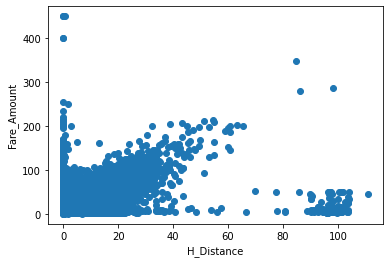

In [50]:
# Plot Fare_Amount vs H_Distance
plt.scatter(filtered['H_Distance'], filtered['fare_amount'])
plt.xlabel('H_Distance')
plt.ylabel('Fare_Amount')
plt.show()

From the Above Plot, we see there is definitely a high corellation but also see a flat horizontal line in the bottom right.
This might be due to fixed prices to airport or some landmarks.

Hence, we need some other way to Impute the Distance Values

In New York, the Base Fee of a Taxi is $2.50$ and after that the fare is $1.56$ per km.

Reference: https://taxi-calculator.com/taxi-fare-new-york-city/259#:~:text=How%20much%20is%20the%20taxi,%3A00pm%20until%206%3A00am.

Hence, we will Impute Distance values by: $H\_Distance = (fare\_amount - 2.50)/1.56$

In [51]:
train[train['H_Distance'] <= 0].shape

(10469, 14)

Imputation

In [52]:
# Now imputing these,
# Fill All Zeros in H_Distance by (Fare_Amount-2.50)/1.56
train.loc[train['H_Distance'] == 0, 'H_Distance'] = (train['fare_amount'] - 2.50) / 1.56

In [53]:
print("Shape of Train: ", train.shape)
print("Shape of Test: ", test.shape)

Shape of Train:  (975512, 14)
Shape of Test:  (9914, 13)


In [54]:
train[train['H_Distance'] <= 0].shape

(718, 14)

Still, 718 rows have H_Distance = 0. This is becausen these rides have an exact fare amount of 2.50

This maybe because the Taxis might have been cancelled after booking the ride hence, the distance is 0 and were only charged base_amount

In [55]:
train.shape, test.shape

((975512, 14), (9914, 13))

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 975512 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        975512 non-null  float64
 1   pickup_longitude   975512 non-null  float64
 2   pickup_latitude    975512 non-null  float64
 3   dropoff_longitude  975512 non-null  float64
 4   dropoff_latitude   975512 non-null  float64
 5   passenger_count    975512 non-null  int64  
 6   hour               975512 non-null  int64  
 7   day_of_week        975512 non-null  int64  
 8   day_of_month       975512 non-null  int64  
 9   week               975512 non-null  UInt32 
 10  month              975512 non-null  int64  
 11  year               975512 non-null  int64  
 12  H_Distance         975512 non-null  float64
 13  Chebyshev          975512 non-null  float64
dtypes: UInt32(1), float64(7), int64(6)
memory usage: 141.1 MB


Distance from Airport can also be an important feature as Taxis charge different at the airport. 
(Also seen at Raipur Train Station).

In [57]:
# There are 3 airports in NY
jfk_coords = (40.639722, -73.778889)
ewr_coords = (40.6925, -74.168611)
lga_coords = (40.77725, -73.872611)

# More Landmarks
sol_coords = (40.689247, -74.044502) # Statue of Liberty
esm_coords = (40.748440, -73.985664) # Empire State Building
cp_coords = (40.782864, -73.965355) # Central Park
ts_cords = (40.759010, -73.984474) # Times Square

Adding Distances from Airports

In [58]:
def add_haversine_dist_from(dataset, airport_coordinates, lat_col, long_col, target_name):
    
    R = 6371  #radius of earth in kilometers
    #R = 3959 #radius of earth in miles
    phi1 = np.radians(dataset[lat_col])
    phi2 = np.radians(airport_coordinates[0])

    delta_phi = np.radians(airport_coordinates[0] - dataset[lat_col])
    delta_lambda = np.radians(airport_coordinates[1] - dataset[long_col])

    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2

    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    #d = R*c
    d = (R * c) #in kilometers
    dataset[target_name] = d


In [59]:
# Add Haversine Distances from Airports

# JFK
# Train
add_haversine_dist_from(train, jfk_coords, 'pickup_latitude', 'pickup_longitude', 'jfk_Distance_Pickup')
add_haversine_dist_from(train, jfk_coords, 'dropoff_latitude', 'dropoff_longitude', 'jfk_Distance_Dropoff')
# Test
add_haversine_dist_from(test, jfk_coords, 'pickup_latitude', 'pickup_longitude', 'jfk_Distance_Pickup')
add_haversine_dist_from(test, jfk_coords, 'dropoff_latitude', 'dropoff_longitude', 'jfk_Distance_Dropoff')

# EWR
# Train
add_haversine_dist_from(train, ewr_coords, 'pickup_latitude', 'pickup_longitude', 'ewr_Distance_Pickup')
add_haversine_dist_from(train, ewr_coords, 'dropoff_latitude', 'dropoff_longitude', 'ewr_Distance_Dropoff')
# Test
add_haversine_dist_from(test, ewr_coords, 'pickup_latitude', 'pickup_longitude', 'ewr_Distance_Pickup')
add_haversine_dist_from(test, ewr_coords, 'dropoff_latitude', 'dropoff_longitude', 'ewr_Distance_Dropoff')

# LGA
# Train
add_haversine_dist_from(train, lga_coords, 'pickup_latitude', 'pickup_longitude', 'lga_Distance_Pickup')
add_haversine_dist_from(train, lga_coords, 'dropoff_latitude', 'dropoff_longitude', 'lga_Distance_Dropoff')
# Test
add_haversine_dist_from(test, lga_coords, 'pickup_latitude', 'pickup_longitude', 'lga_Distance_Pickup')
add_haversine_dist_from(test, lga_coords, 'dropoff_latitude', 'dropoff_longitude', 'lga_Distance_Dropoff')

# SOL
# Train
add_haversine_dist_from(train, sol_coords, 'pickup_latitude', 'pickup_longitude', 'sol_Distance_Pickup')
add_haversine_dist_from(train, sol_coords, 'dropoff_latitude', 'dropoff_longitude', 'sol_Distance_Dropoff')
# Test
add_haversine_dist_from(test, sol_coords, 'pickup_latitude', 'pickup_longitude', 'sol_Distance_Pickup')
add_haversine_dist_from(test, sol_coords, 'dropoff_latitude', 'dropoff_longitude', 'sol_Distance_Dropoff')

# ESM
# Train
add_haversine_dist_from(train, esm_coords, 'pickup_latitude', 'pickup_longitude', 'esm_Distance_Pickup')
add_haversine_dist_from(train, esm_coords, 'dropoff_latitude', 'dropoff_longitude', 'esm_Distance_Dropoff')
# Test
add_haversine_dist_from(test, esm_coords, 'pickup_latitude', 'pickup_longitude', 'esm_Distance_Pickup')
add_haversine_dist_from(test, esm_coords, 'dropoff_latitude', 'dropoff_longitude', 'esm_Distance_Dropoff')

# CP
# Train
add_haversine_dist_from(train, cp_coords, 'pickup_latitude', 'pickup_longitude', 'cp_Distance_Pickup')
add_haversine_dist_from(train, cp_coords, 'dropoff_latitude', 'dropoff_longitude', 'cp_Distance_Dropoff')
# Test
add_haversine_dist_from(test, cp_coords, 'pickup_latitude', 'pickup_longitude', 'cp_Distance_Pickup')
add_haversine_dist_from(test, cp_coords, 'dropoff_latitude', 'dropoff_longitude', 'cp_Distance_Dropoff')

# TS
# Train
add_haversine_dist_from(train, ts_cords, 'pickup_latitude', 'pickup_longitude', 'ts_Distance_Pickup')
add_haversine_dist_from(train, ts_cords, 'dropoff_latitude', 'dropoff_longitude', 'ts_Distance_Dropoff')
# Test
add_haversine_dist_from(test, ts_cords, 'pickup_latitude', 'pickup_longitude', 'ts_Distance_Pickup')
add_haversine_dist_from(test, ts_cords, 'dropoff_latitude', 'dropoff_longitude', 'ts_Distance_Dropoff')

In [60]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_week,day_of_month,week,...,lga_Distance_Pickup,lga_Distance_Dropoff,sol_Distance_Pickup,sol_Distance_Dropoff,esm_Distance_Pickup,esm_Distance_Dropoff,cp_Distance_Pickup,cp_Distance_Dropoff,ts_Distance_Pickup,ts_Distance_Dropoff
count,975512.000000,975512.000000,975512.000000,975512.000000,975512.000000,975512.000000,975512.000000,975512.000000,975512.000000,975512.000000,...,975512.000000,975512.000000,975512.000000,975512.000000,975512.000000,975512.000000,975512.000000,975512.000000,975512.000000,975512.000000
mean,11.338983,-73.975090,40.751112,-73.974207,40.751450,1.691054,13.509169,3.039569,15.692263,25.471186,...,9.780711,9.794095,9.378105,9.541171,3.048658,3.345161,4.540644,4.693216,3.095346,3.370932
std,9.724820,0.038571,0.029581,0.037747,0.032758,1.306180,6.511871,1.949817,8.682335,14.952021,...,2.939130,2.981292,3.868457,3.908484,3.598993,3.636284,3.725686,3.754471,3.630234,3.668647
min,0.010000,-74.481853,40.500046,-74.475731,40.500046,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.128584,0.163085,0.242664,0.049052,0.006394,0.003518,0.043905,0.085794,0.001455,0.002055
25%,6.000000,-73.992269,40.736580,-73.991570,40.735592,1.000000,9.000000,1.000000,8.000000,13.000000,...,8.495141,8.431252,7.028323,7.164145,1.302743,1.350117,2.287158,2.316308,1.256236,1.286598
50%,8.500000,-73.982082,40.753413,-73.980590,40.753875,1.000000,14.000000,3.000000,16.000000,24.000000,...,9.733761,9.642425,9.025166,9.128180,2.172021,2.348933,3.879125,3.945740,2.369101,2.518400
75%,12.500000,-73.968312,40.767580,-73.965317,40.768419,2.000000,19.000000,5.000000,23.000000,39.000000,...,11.141705,11.107974,11.031141,11.316126,3.718072,4.200391,5.968884,6.160411,3.708030,4.039177
max,500.000000,-72.856968,41.696852,-72.848088,41.714633,6.000000,23.000000,6.000000,31.000000,53.000000,...,112.175807,111.297419,127.348489,123.918344,119.212036,115.733761,115.027649,111.978836,118.124707,114.795148


In [61]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_week,day_of_month,week,month,...,lga_Distance_Pickup,lga_Distance_Dropoff,sol_Distance_Pickup,sol_Distance_Dropoff,esm_Distance_Pickup,esm_Distance_Dropoff,cp_Distance_Pickup,cp_Distance_Dropoff,ts_Distance_Pickup,ts_Distance_Dropoff
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,...,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,13.467420,2.852834,16.194170,28.161892,6.857979,...,9.859514,9.794059,9.408034,9.602030,3.110174,3.423486,4.626072,4.725629,3.166598,3.440518
std,0.042774,0.033541,0.039072,0.035435,1.278747,6.868584,1.994451,8.838482,14.523575,3.353272,...,3.478215,3.298067,4.488431,4.251334,4.256197,3.970950,4.312041,4.057053,4.276200,3.996899
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.341748,0.304281,2.653346,2.591499,0.044825,0.020869,0.403857,0.159656,0.001813,0.019469
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,8.000000,1.000000,9.000000,17.000000,4.000000,...,8.508710,8.424712,6.960193,7.211769,1.330250,1.361052,2.298060,2.302783,1.258536,1.278496
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,15.000000,3.000000,16.000000,29.000000,7.000000,...,9.790240,9.600853,8.997757,9.157657,2.169560,2.417977,3.961655,3.931897,2.394848,2.565409
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,19.000000,5.000000,25.000000,40.000000,10.000000,...,11.200264,11.091945,11.000745,11.389731,3.694844,4.294014,6.029124,6.180836,3.728767,4.113111
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,23.000000,6.000000,31.000000,53.000000,12.000000,...,127.416695,126.042194,143.895195,142.545309,135.654943,134.305546,131.584044,130.239271,134.665119,133.318622


Let's add 14 new features:

1. Is the Pickup near JFK Airport?
2. Is the Pickup near LGA Airport?
3. Is the Pickup near EWR Airport?
4. Is the Dropoff near JFK Airport?
5. Is the Dropoff near LGA Airport?
6. Is the Dropoff near EWR Airport?
7. Is the Pickup near Statue of Liberty?
8. Is the Pickup near Central Park?
9. Is the Pickup near Times Square?
10. Is the Dropoff near Statue of Liberty?
11. Is the Dropoff near Central Park?
12. Is the Dropoff near Times Square?
13. Is the Pickup near Empire State Building?
14. Is the Dropoff near Empire State Building?

We will consider a radius of 4 KM

In [62]:
# Create a boolean feature if pickup distance with JFK is less than 4 KM
train['pickup_near_jfk'] = train['jfk_Distance_Pickup'].apply(lambda x: 1 if x < 4 else 0)

# Create a boolean feature if dropoff distance with JFK is less than 4 KM
train['dropoff_near_jfk'] = train['jfk_Distance_Dropoff'].apply(lambda x: 1 if x < 4 else 0)

# Create a boolean feature if pickup distance with EWR is less than 4 KM
train['pickup_near_ewr'] = train['ewr_Distance_Pickup'].apply(lambda x: 1 if x < 4 else 0)

# Create a boolean feature if dropoff distance with EWR is less than 4 KM
train['dropoff_near_ewr'] = train['ewr_Distance_Dropoff'].apply(lambda x: 1 if x < 4 else 0)

# Create a boolean feature if pickup distance with LGA is less than 4 KM
train['pickup_near_lga'] = train['lga_Distance_Pickup'].apply(lambda x: 1 if x < 4 else 0)

# Create a boolean feature if dropoff distance with LGA is less than 4 KM
train['dropoff_near_lga'] = train['lga_Distance_Dropoff'].apply(lambda x: 1 if x < 4 else 0)

# Create a boolean feature if pickup distance with SOL is less than 4 KM
train['pickup_near_sol'] = train['sol_Distance_Pickup'].apply(lambda x: 1 if x < 4 else 0)

# Create a boolean feature if dropoff distance with SOL is less than 4 KM 
train['dropoff_near_sol'] = train['sol_Distance_Dropoff'].apply(lambda x: 1 if x < 4 else 0)

# Create a boolean feature if pickup distance with ESM is less than 4 KM
train['pickup_near_esm'] = train['esm_Distance_Pickup'].apply(lambda x: 1 if x < 4 else 0)

# Create a boolean feature if dropoff distance with ESM is less than 4 KM
train['dropoff_near_esm'] = train['esm_Distance_Dropoff'].apply(lambda x: 1 if x < 4 else 0)

# Create a boolean feature if pickup distance with CP is less than 4 KM
train['pickup_near_cp'] = train['cp_Distance_Pickup'].apply(lambda x: 1 if x < 4 else 0)

# Create a boolean feature if dropoff distance with CP is less than 4 KM
train['dropoff_near_cp'] = train['cp_Distance_Dropoff'].apply(lambda x: 1 if x < 4 else 0)

# Create a boolean feature if pickup distance with TS is less than 4 KM
train['pickup_near_ts'] = train['ts_Distance_Pickup'].apply(lambda x: 1 if x < 4 else 0)

# Create a boolean feature if dropoff distance with TS is less than 4 KM
train['dropoff_near_ts'] = train['ts_Distance_Dropoff'].apply(lambda x: 1 if x < 4 else 0)

Checking Correlation

In [63]:
abs(train.corr()['fare_amount']).sort_values(ascending=False)

fare_amount             1.000000
Chebyshev               0.832589
H_Distance              0.831433
ts_Distance_Dropoff     0.475130
esm_Distance_Dropoff    0.468641
cp_Distance_Dropoff     0.417248
pickup_near_jfk         0.414813
ts_Distance_Pickup      0.398518
esm_Distance_Pickup     0.393216
pickup_longitude        0.381132
jfk_Distance_Pickup     0.378749
cp_Distance_Pickup      0.346377
dropoff_near_ts         0.337596
ewr_Distance_Pickup     0.319232
dropoff_near_jfk        0.313263
dropoff_near_esm        0.306727
dropoff_longitude       0.293109
pickup_near_ts          0.271128
pickup_near_lga         0.270271
ewr_Distance_Dropoff    0.269281
sol_Distance_Pickup     0.264743
sol_Distance_Dropoff    0.263408
pickup_near_esm         0.242832
jfk_Distance_Dropoff    0.241167
dropoff_near_ewr        0.223381
dropoff_near_lga        0.216353
pickup_latitude         0.187417
dropoff_near_cp         0.165575
dropoff_latitude        0.152979
lga_Distance_Dropoff    0.140755
pickup_nea

A large database requires a large computing resource, with this function, we will reduce the numerical types to the minimum possible size, which will simplify the calculations

In [64]:
def downcast(df):

    df_int = df.select_dtypes(include=['int64', 'int32', 'int16', 'int8', 'int'])
    df[df_int.columns] = df_int.apply(pd.to_numeric,downcast='unsigned')
    
    df_float = df.select_dtypes(include=['float64', 'float32', 'float16', 'float'])
    df[df_float.columns] = df_float.apply(pd.to_numeric,downcast='float')
        
    return df

downcast(train)
downcast(test)

train.dtypes

fare_amount             float32
pickup_longitude        float32
pickup_latitude         float32
dropoff_longitude       float32
dropoff_latitude        float32
passenger_count           uint8
hour                      uint8
day_of_week               uint8
day_of_month              uint8
week                     UInt32
month                     uint8
year                     uint16
H_Distance              float32
Chebyshev               float32
jfk_Distance_Pickup     float32
jfk_Distance_Dropoff    float32
ewr_Distance_Pickup     float32
ewr_Distance_Dropoff    float32
lga_Distance_Pickup     float32
lga_Distance_Dropoff    float32
sol_Distance_Pickup     float32
sol_Distance_Dropoff    float32
esm_Distance_Pickup     float32
esm_Distance_Dropoff    float32
cp_Distance_Pickup      float32
cp_Distance_Dropoff     float32
ts_Distance_Pickup      float32
ts_Distance_Dropoff     float32
pickup_near_jfk           uint8
dropoff_near_jfk          uint8
pickup_near_ewr           uint8
dropoff_

Plotting the Data on a MAP and visualizing it

In [65]:
# import folium

# long_trips=train[train['H_Distance']>=10]

# drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 12)

# ### For each pickup point add a circlemarker

# for index, row in long_trips.iterrows():
    
#     folium.CircleMarker([row['dropoff_latitude'], row['dropoff_longitude']],
#                         radius=3,
#                         color="green", 
#                         fill_opacity=0.9
#                        ).add_to(drop_map)
# for index, row in long_trips.iterrows():
    
#     folium.CircleMarker([row['pickup_latitude'], row['pickup_longitude']],
#                         radius=3,
#                         color="blue", 
#                         fill_opacity=0.9
#                        ).add_to(drop_map)
# drop_map

# EDA

Checking if the Dependent Variable is Normally Distributed

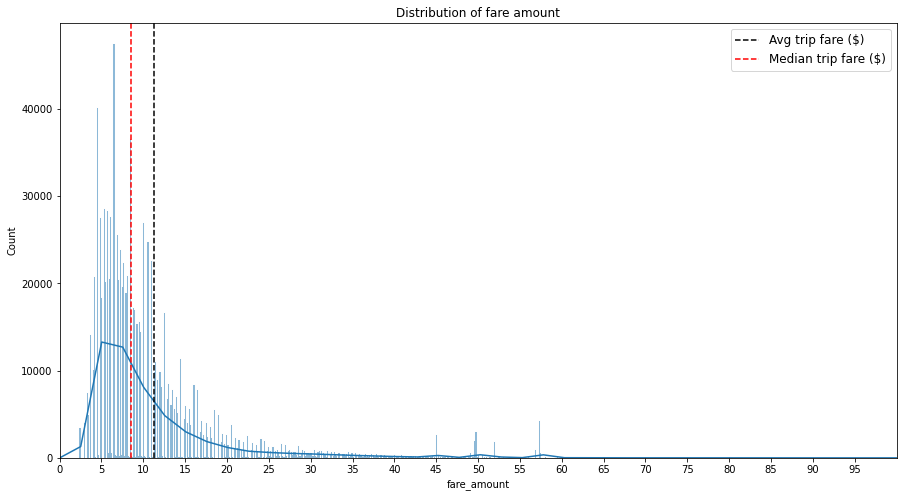

In [66]:
sns.histplot(data=train,x="fare_amount",kde=True)

plt.axvline(train["fare_amount"].mean(),color = "k",
            linestyle = "dashed",label = "Avg trip fare ($)")
plt.axvline(train["fare_amount"].median(),color = "r",
            linestyle = "dashed",label = "Median trip fare ($)")

plt.title("Distribution of fare amount")
plt.xticks(np.arange(0, 100, step=5))
plt.legend(loc = "best",prop = {"size" : 12})
plt.gcf().set_size_inches(15,8)
plt.xlim(0,100)
plt.show()

Clearly, the dependent variable is Normally Distributed but is Right-Skewed.

Now we will check the following 4 things as asked in the Starter Code:
1. Does the number of passengers affect the fare?
2. Does the date and time of pickup affect the fare?
3. Does the day of the week affect the fare?
4. Does the distance travelled affect the fare?



**1. Does the number of passengers affect the fare?**

Text(0, 0.5, 'Frequency')

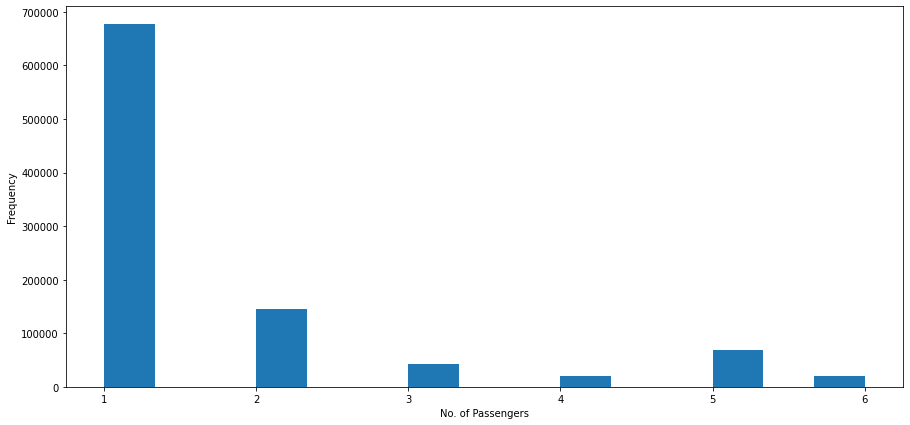

In [67]:
plt.figure(figsize=(15,7))
plt.hist(train['passenger_count'], bins=15)
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

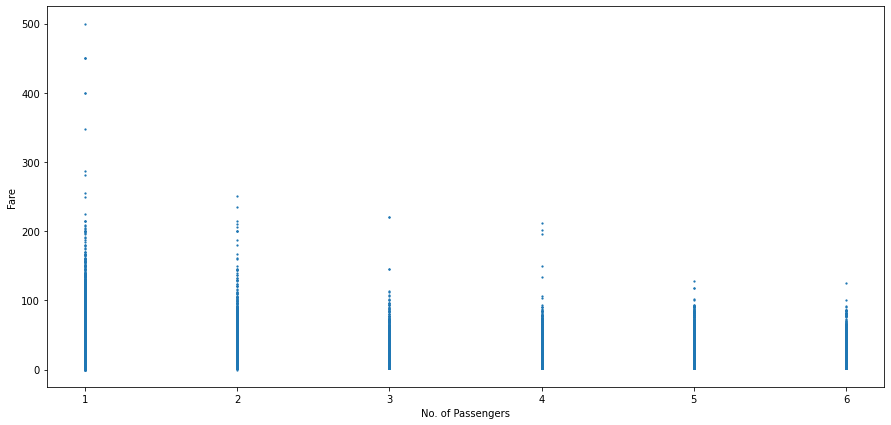

In [68]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['passenger_count'], y=train['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

**Inference:**

We can see that the highest fares are coming from the Taxi with 1 passenger and Taxis with 1 passengers are the most frequent.

I do not think that fare should depend on the number of passengers. This might be due to the fact that the taxis with 1 passengers might be travelling longer distances. We will check for it later. For now, we are keeping this feature.

Let's check the Correlation

In [69]:
train[['passenger_count', 'fare_amount']].corr()

,passenger_count,fare_amount
passenger_count,1.000000,0.012904
fare_amount,0.012904,1.000000


The Co-Relation Seems to be very low...

**2. Does the pick up date and time affect the fare?**

Checking `Year`

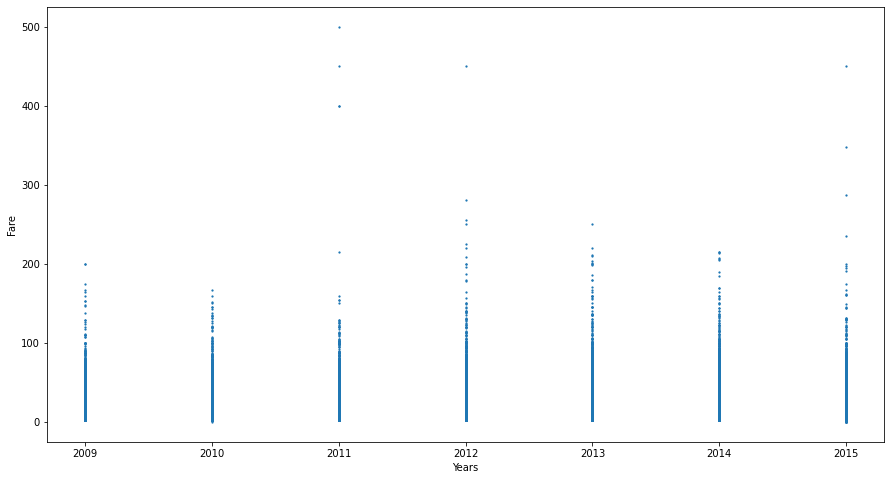

In [70]:
plt.figure(figsize=(15,8))
plt.scatter(x=train['year'], y=train['fare_amount'], s=1.5)
plt.xlabel('Years')
plt.ylabel('Fare')
plt.show()

Fairs dont show any significant change throughout years from this plot..

Checking Correlation

In [71]:
train[['fare_amount','year']].corr()

,fare_amount,year
fare_amount,1.000000,0.116199
year,0.116199,1.000000


Correlation Seems to be Poor

Checking `Month`

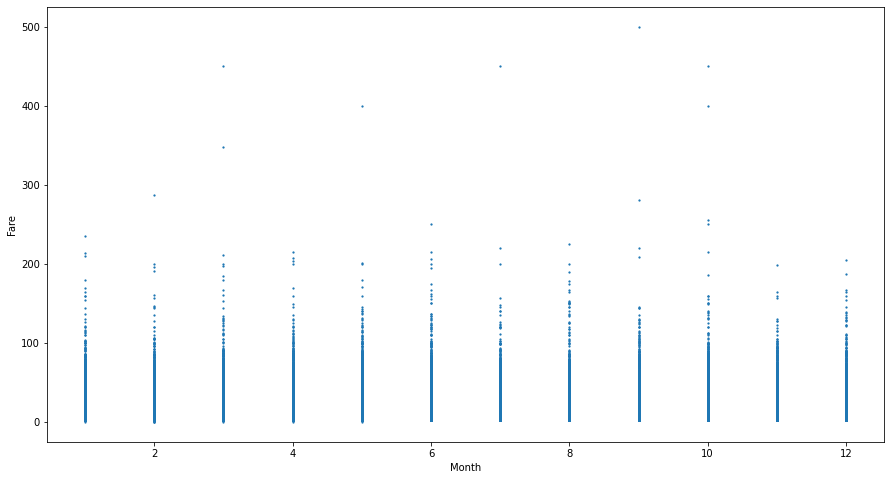

In [72]:
plt.figure(figsize=(15,8))
plt.scatter(x=train['month'], y=train['fare_amount'], s=1.5)
plt.xlabel('Month')
plt.ylabel('Fare')
plt.show()

Fairs dont show any significant throughout months from this plot..

Checking Correlation

In [73]:
train[['fare_amount','month']].corr()

,fare_amount,month
fare_amount,1.000000,0.025175
month,0.025175,1.000000


Month has a very poor corellation with the fare amount.

Checking `Day of Month`

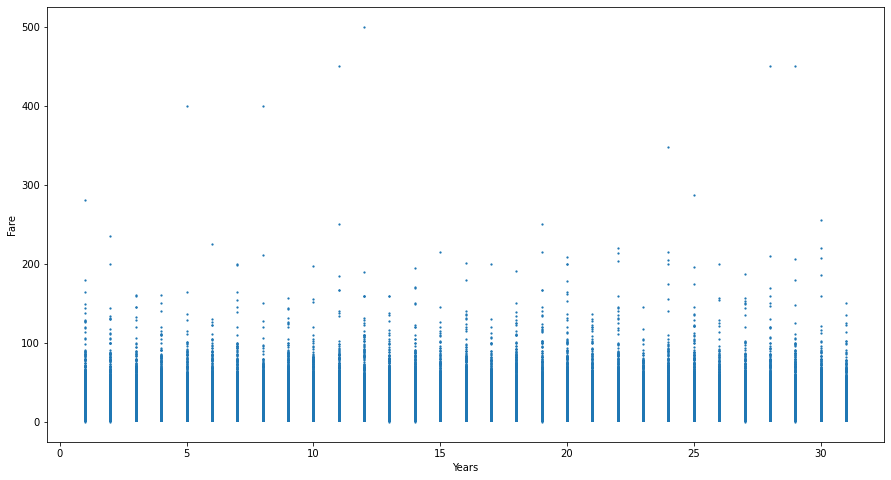

In [74]:
plt.figure(figsize=(15,8))
plt.scatter(x=train['day_of_month'], y=train['fare_amount'], s=1.5)
plt.xlabel('Years')
plt.ylabel('Fare')
plt.show()

Again, no significant change can be seen.

Checking Correlation

In [75]:
train[['fare_amount','day_of_month']].corr()

,fare_amount,day_of_month
fare_amount,1.00000,0.00154
day_of_month,0.00154,1.00000


A very poor Correlation.

### Checking Taxi Frequency Distribution over Different Hours of the Day

Text(0, 0.5, 'Frequency')

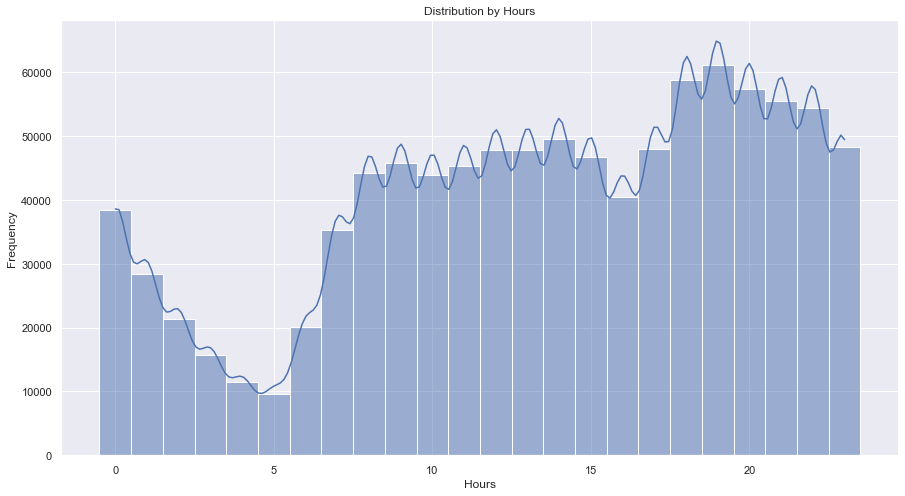

In [76]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data=train, x="hour", stat="count", discrete=True, kde=True)
plt.title("Distribution by Hours")
plt.xlabel('Hours')
plt.ylabel('Frequency')

From above plot, we can see that the taxis peak around 7pm in the evening, and are most rare around 5am in the morning.

### Lets try to visualise the Average Fare Amount as a Time Series

In [77]:
def time_series_visualizer(df, timeframes, value, color="purple"):
    
    # Need to pass minimum of 2 time frames
    
    f, ax = plt.subplots(len(timeframes), figsize = [12,12])
    
    # For All TimeFrames
    for i,x in enumerate(timeframes):
        # We are checking the Average Fare Amount for each TimeFrame hence, we are using "mean"
        df.loc[:,[x,value]].groupby([x]).mean().plot(ax=ax[i],color=color)
        ax[i].set_ylabel(value.replace("_", " ").title())
        ax[i].set_title("{} by {}".format(value.replace("_", " ").title(), x.replace("_", " ").title()))
        ax[i].set_xlabel("")
    
    plt.tight_layout(pad=0)

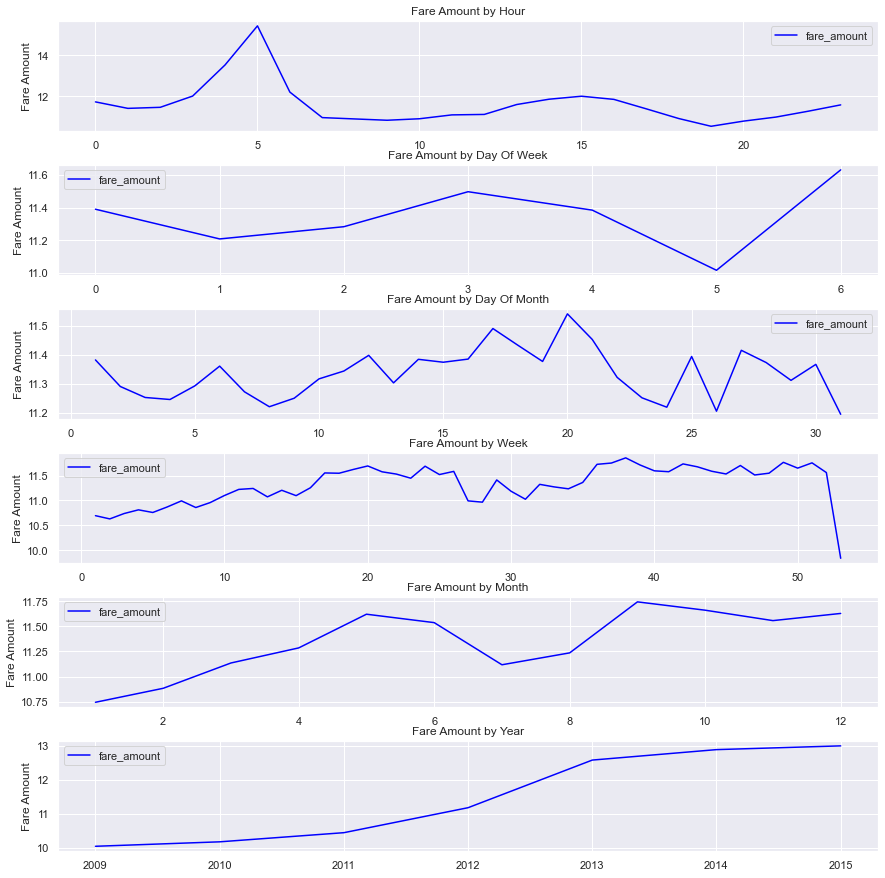

In [78]:
time_series_visualizer(df=train, timeframes=['hour', 'day_of_week','day_of_month', 'week', 'month', 'year'], value = "fare_amount", color="blue")

***Inferences***

1. Average Fare Amount peaks around 5 AM. This might be due to people leaving early are generally leaving for longer travels. This can lead to a new boolean feature which tells us if the Ride is between 4 AM - 6 AM.
2. Average Fares are maximum on Sundays (Day-6). This can lead to a new feature which tells us if the Ride is on a Sunday.
3. Average Fare Amount has been increasing throughout the years. It also had a good corellation with it. It could be a good feature.

### Testing new Features

Checking ifSunday

In [79]:
train['isSunday'] = train['day_of_week'].apply(lambda x: 1 if x == 6 else 0)

Checking correlation

In [80]:
abs(train.corr()['fare_amount']).sort_values(ascending=False)

fare_amount             1.000000
Chebyshev               0.832589
H_Distance              0.831433
ts_Distance_Dropoff     0.475130
esm_Distance_Dropoff    0.468641
cp_Distance_Dropoff     0.417248
pickup_near_jfk         0.414813
ts_Distance_Pickup      0.398518
esm_Distance_Pickup     0.393216
pickup_longitude        0.381132
jfk_Distance_Pickup     0.378749
cp_Distance_Pickup      0.346377
dropoff_near_ts         0.337596
ewr_Distance_Pickup     0.319232
dropoff_near_jfk        0.313263
dropoff_near_esm        0.306727
dropoff_longitude       0.293109
pickup_near_ts          0.271128
pickup_near_lga         0.270271
ewr_Distance_Dropoff    0.269281
sol_Distance_Pickup     0.264743
sol_Distance_Dropoff    0.263408
pickup_near_esm         0.242832
jfk_Distance_Dropoff    0.241167
dropoff_near_ewr        0.223381
dropoff_near_lga        0.216353
pickup_latitude         0.187417
dropoff_near_cp         0.165575
dropoff_latitude        0.152979
lga_Distance_Dropoff    0.140755
pickup_nea

isSunday has more-correlation with the fare amount compared to day_of_week, hence i see this as a complete win!

Checking isAround5AM

In [81]:
# Add a boolean feature if hour is between 4 and 6
train['isAround5AM'] = train['hour'].apply(lambda x: 1 if x >= 4 and x <= 5 else 0)

Checking Correlation

In [82]:
abs(train.corr()['fare_amount']).sort_values(ascending=False)

fare_amount             1.000000
Chebyshev               0.832589
H_Distance              0.831433
ts_Distance_Dropoff     0.475130
esm_Distance_Dropoff    0.468641
cp_Distance_Dropoff     0.417248
pickup_near_jfk         0.414813
ts_Distance_Pickup      0.398518
esm_Distance_Pickup     0.393216
pickup_longitude        0.381132
jfk_Distance_Pickup     0.378749
cp_Distance_Pickup      0.346377
dropoff_near_ts         0.337596
ewr_Distance_Pickup     0.319232
dropoff_near_jfk        0.313263
dropoff_near_esm        0.306727
dropoff_longitude       0.293109
pickup_near_ts          0.271128
pickup_near_lga         0.270271
ewr_Distance_Dropoff    0.269281
sol_Distance_Pickup     0.264743
sol_Distance_Dropoff    0.263408
pickup_near_esm         0.242832
jfk_Distance_Dropoff    0.241167
dropoff_near_ewr        0.223381
dropoff_near_lga        0.216353
pickup_latitude         0.187417
dropoff_near_cp         0.165575
dropoff_latitude        0.152979
lga_Distance_Dropoff    0.140755
pickup_nea

It has more correlation with the fare amount than hour has with fare_amount, so this is also an upgrade!

### Trying to Visualize the Average Distance Travelled as a Time Series

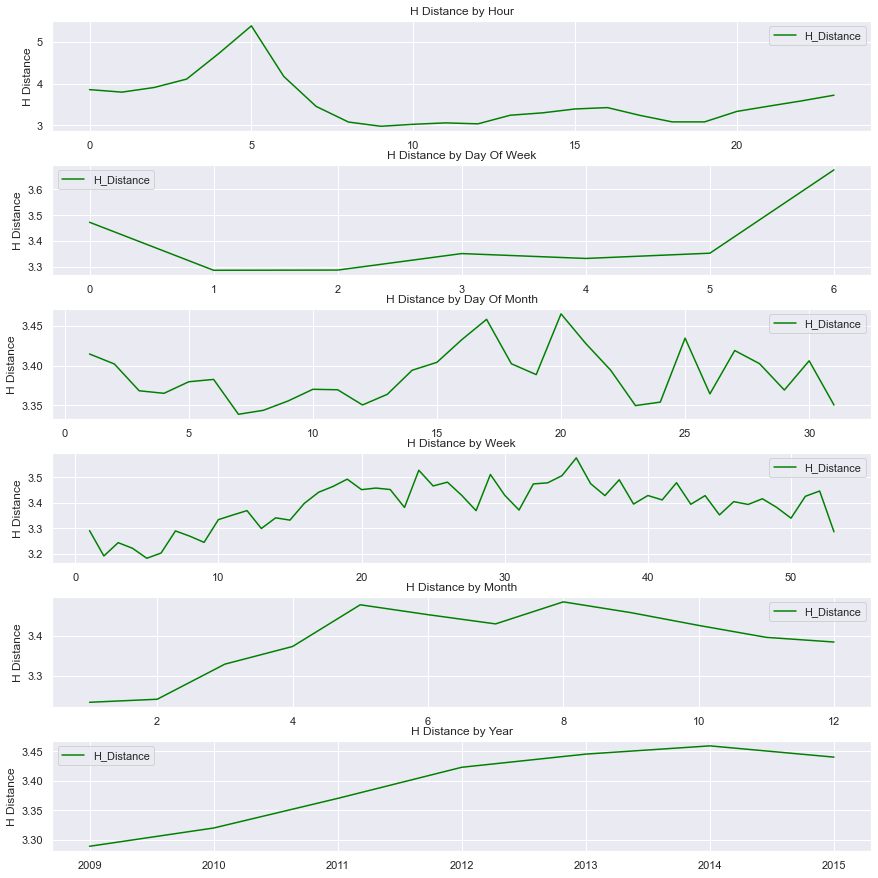

In [83]:
time_series_visualizer(df=train, timeframes=['hour', 'day_of_week','day_of_month', 'week', 'month', 'year'], value = "H_Distance", color="green")

***Inferences***

- The plots seem to be very similar to the Average Fare Amount Time Series.

This means Distance can be highly co-related. We will check that when we are focusing on the 4th point

***3. Does the day of the week affect the fare?***

Checking Frequency of Rides during Weekdays

Text(0, 0.5, 'Frequency')

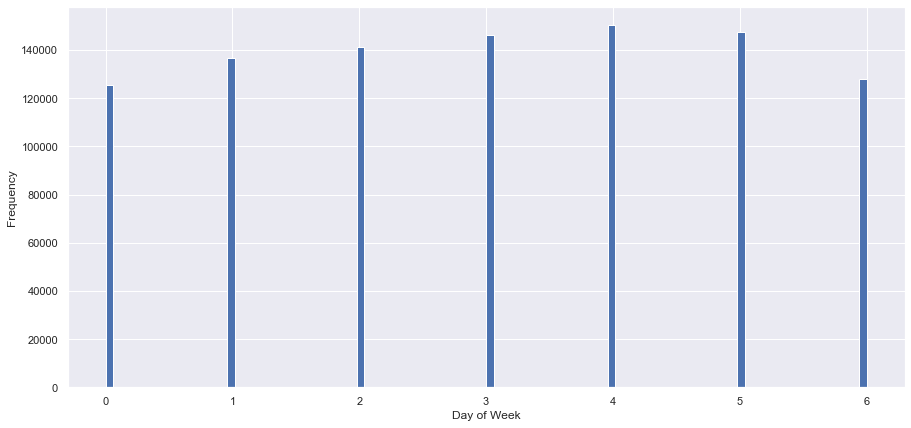

In [84]:
plt.figure(figsize=(15,7))
plt.hist(train['day_of_week'], bins=100)
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

The Frequency of Rides does not change much or show any significant pattern.

Checking Fares throughout the Weekdays

Text(0, 0.5, 'Fare')

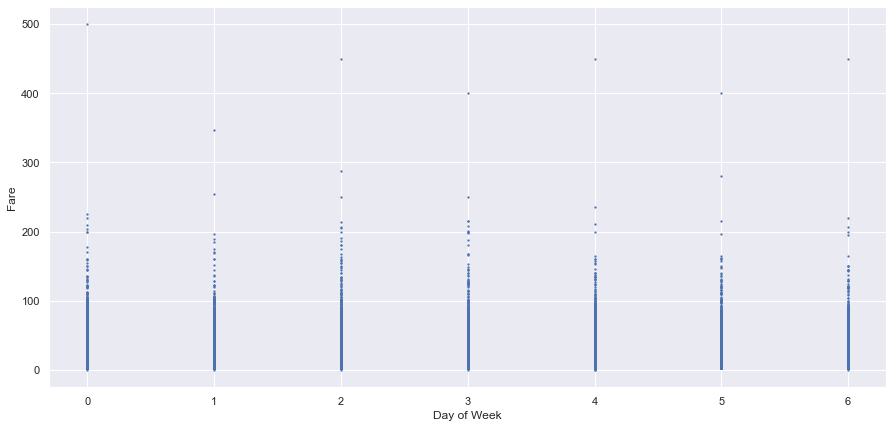

In [85]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['day_of_week'], y=train['fare_amount'], s=1.5)
plt.xlabel('Day of Week')
plt.ylabel('Fare')

The Highest Fares are on Monday and Sunday.

Checking the Average Fare Amount throughout the Weekdays

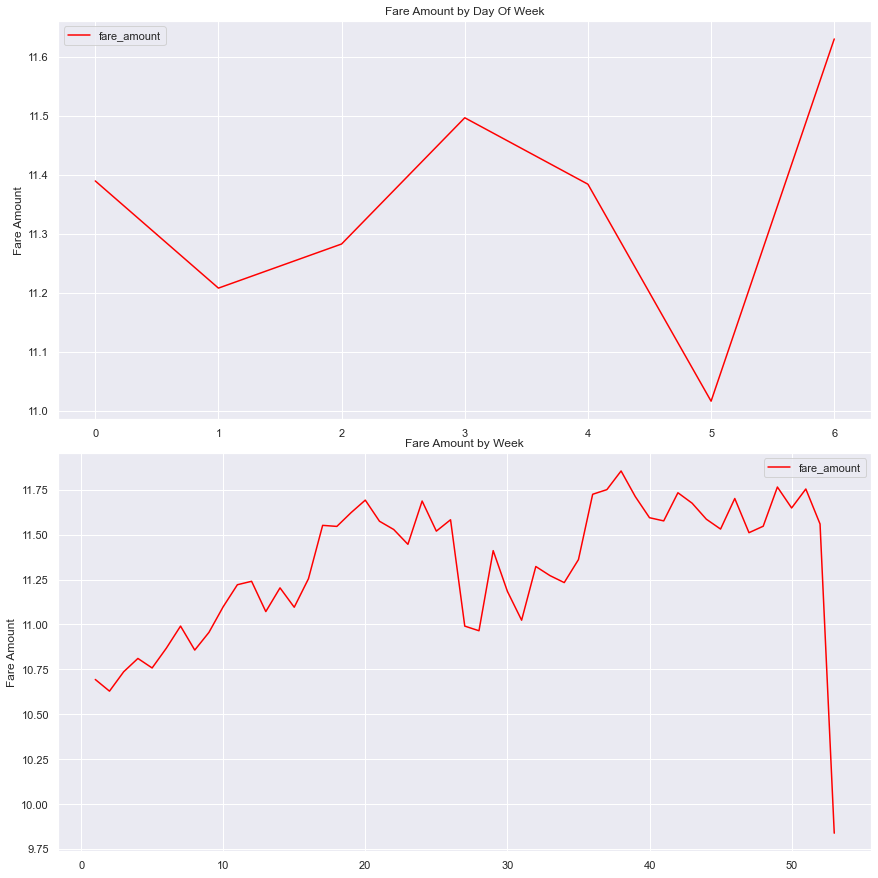

In [86]:
time_series_visualizer(df=train, timeframes=['day_of_week', 'week'], value = "fare_amount", color="red")

The Average Fare Amount is highest on Sundays. This might be due to people travelling longer distances to visit family, friends, etc on weekends?

Checking Corellation

In [87]:
train[['fare_amount','day_of_week']].corr()

,fare_amount,day_of_week
fare_amount,1.0000,0.0026
day_of_week,0.0026,1.0000


The Corellation is not very good, but the day of week definitely affects the fare prices.

***4. Does the distance travelled affect the fare?***

As we saw earlier, the Average Distance Time Series plots are very similar to the Average Fare Amount Time Series plots

Checking Correlation

In [88]:
train[['fare_amount','H_Distance']].corr()

,fare_amount,H_Distance
fare_amount,1.000000,0.831433
H_Distance,0.831433,1.000000


Clearly, this is a very high and good Correlation. 
Hence, Distance is the most important Feature both Intuitively and Statistically.

# FEATURE SELECTION

### Visualizing Histograms of all features

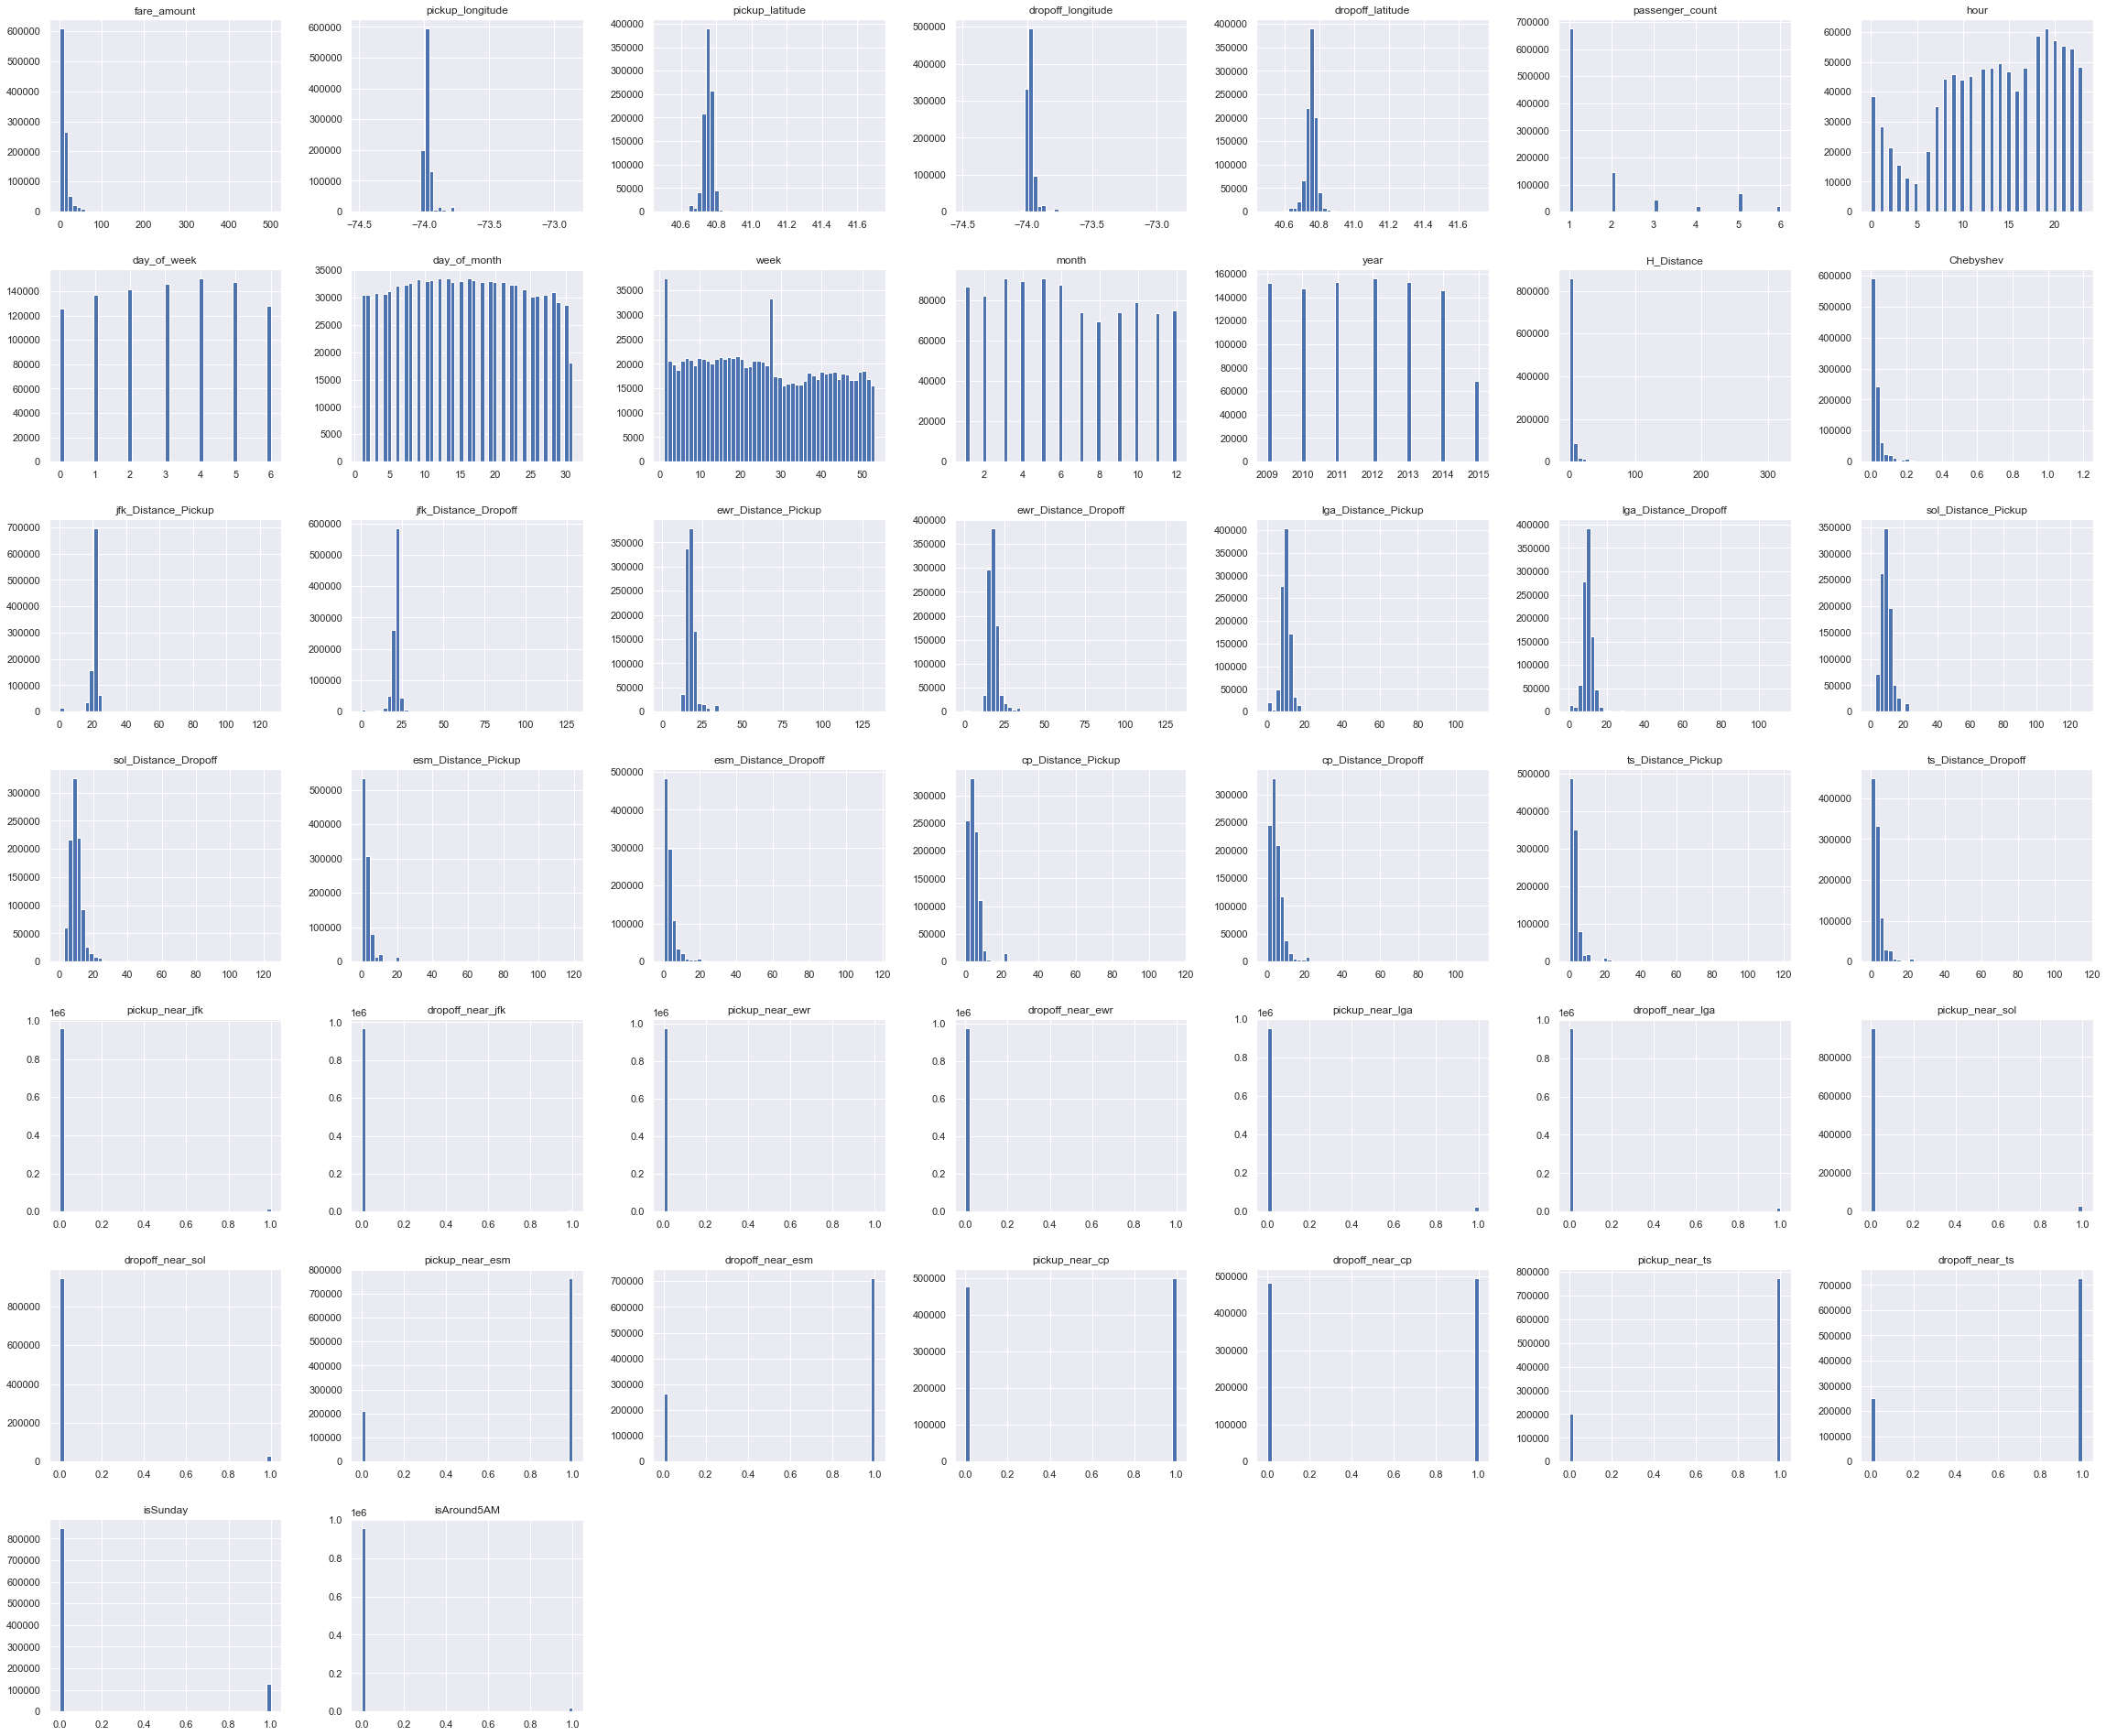

In [89]:
train.hist(bins=50, figsize=(40,34))
plt.show()

From the above plots, we see alot of features are Normally Distributed but are skewed.

### Need to remove Correlated Independent Variables

Text(0.5, 1.0, 'Correlation Heatmap')

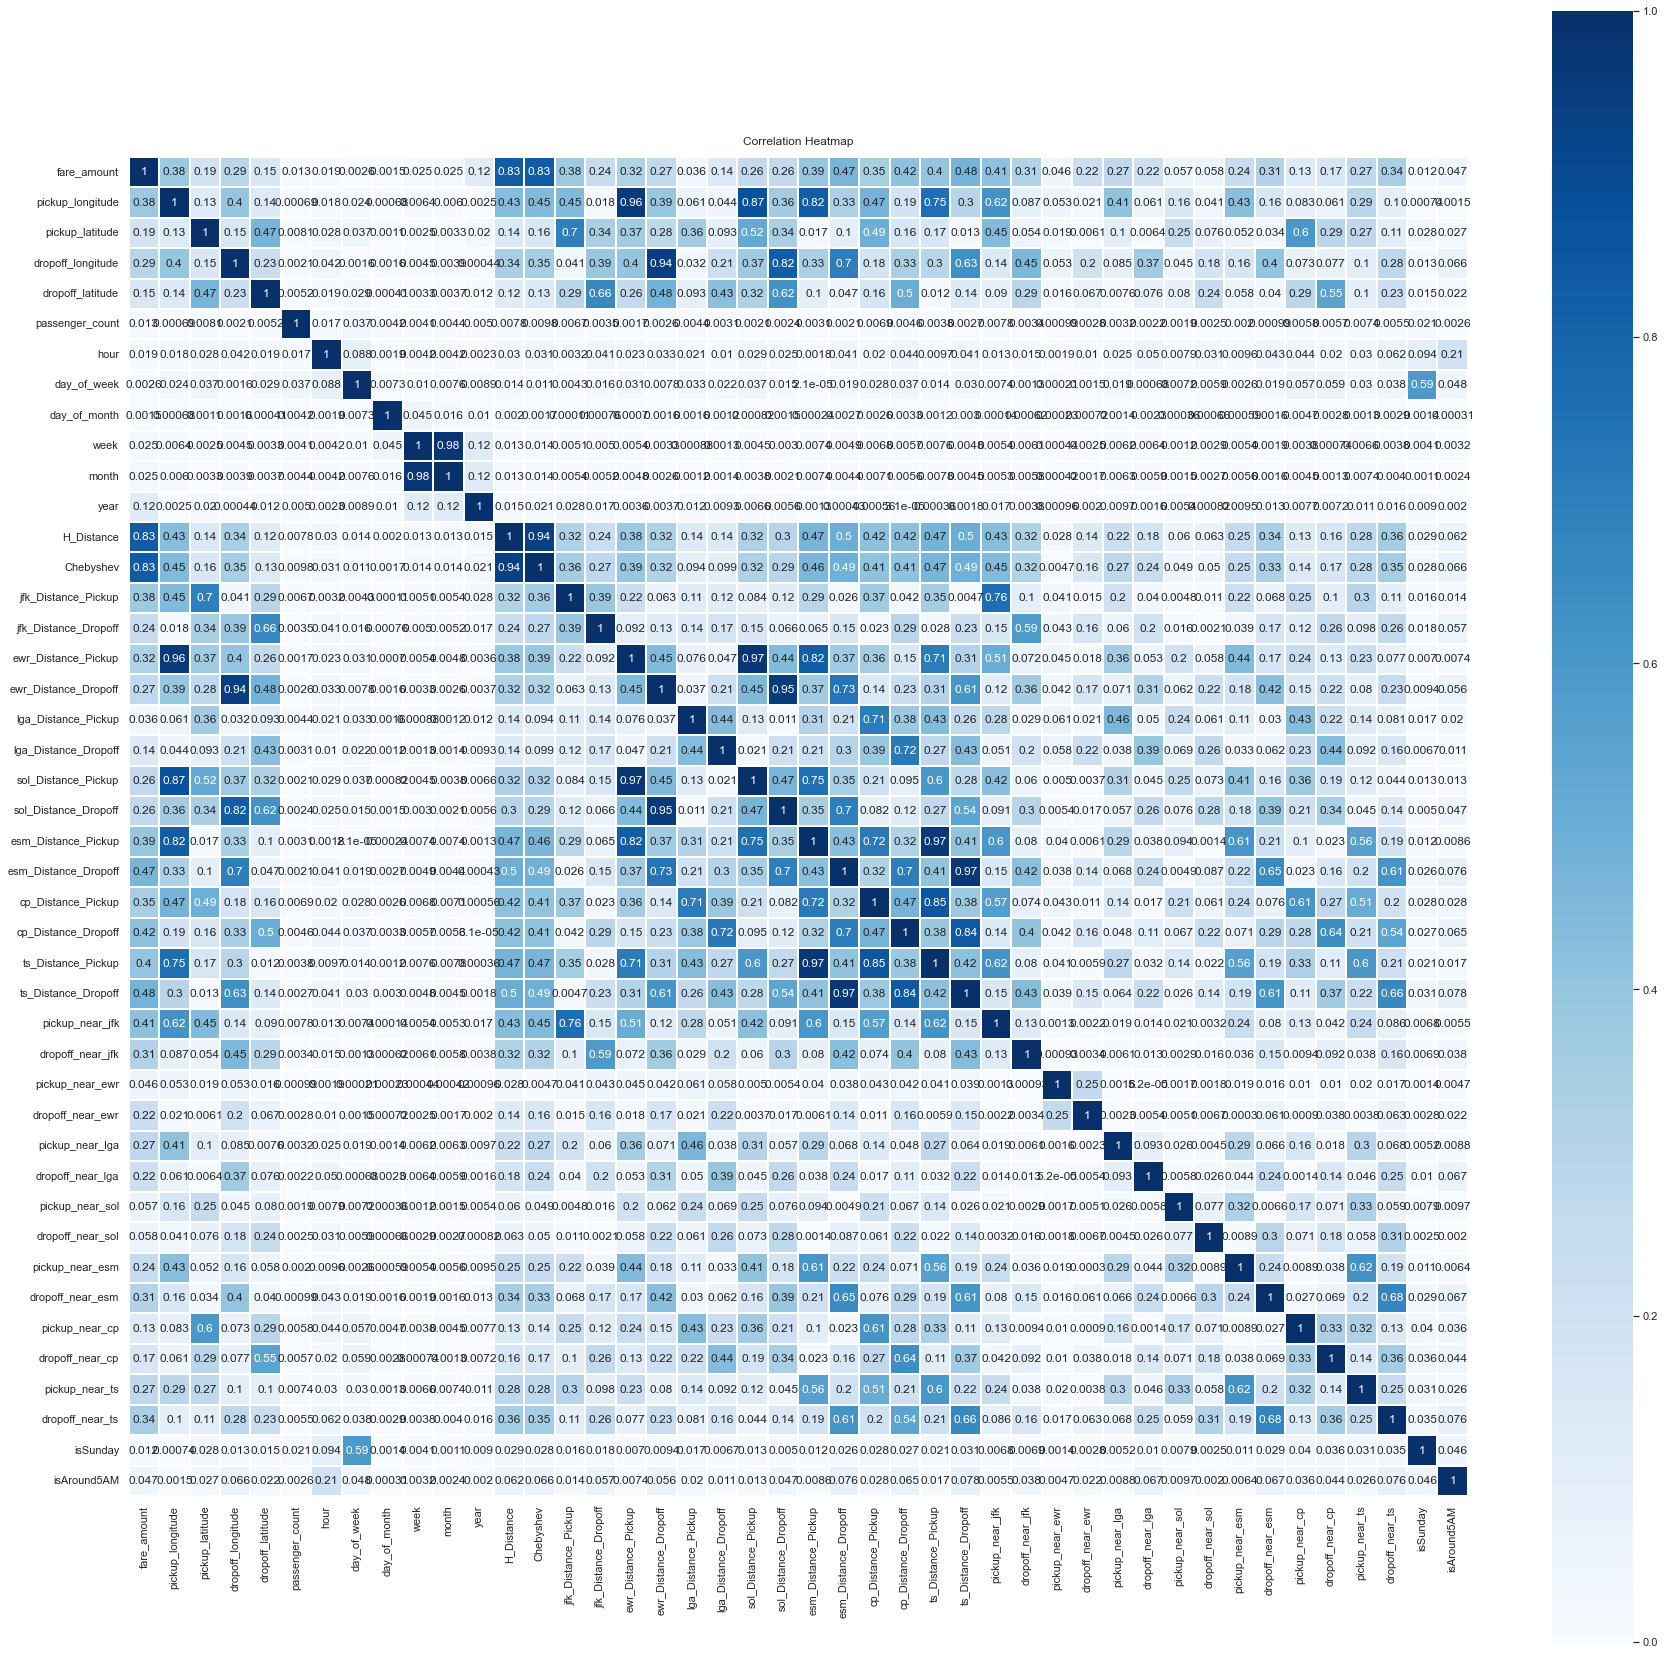

In [90]:
colormap = plt.cm.RdBu
plt.figure(figsize=(30, 30))
heatmap = sns.heatmap(abs(train.corr()),linewidths=0.1,vmax=1.0,vmin=0, 
            square=True, cmap="Blues", linecolor='white', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

From the Above Plot, we check the Features which have good Correlation (> 0.2) with the Fare Amount.

In [91]:
# Features with Correlation more than 0.1 with Fare Amount
abs(train.corr()['fare_amount']).sort_values(ascending=False)

fare_amount             1.000000
Chebyshev               0.832589
H_Distance              0.831433
ts_Distance_Dropoff     0.475130
esm_Distance_Dropoff    0.468641
cp_Distance_Dropoff     0.417248
pickup_near_jfk         0.414813
ts_Distance_Pickup      0.398518
esm_Distance_Pickup     0.393216
pickup_longitude        0.381132
jfk_Distance_Pickup     0.378749
cp_Distance_Pickup      0.346377
dropoff_near_ts         0.337596
ewr_Distance_Pickup     0.319232
dropoff_near_jfk        0.313263
dropoff_near_esm        0.306727
dropoff_longitude       0.293109
pickup_near_ts          0.271128
pickup_near_lga         0.270271
ewr_Distance_Dropoff    0.269281
sol_Distance_Pickup     0.264743
sol_Distance_Dropoff    0.263408
pickup_near_esm         0.242832
jfk_Distance_Dropoff    0.241167
dropoff_near_ewr        0.223381
dropoff_near_lga        0.216353
pickup_latitude         0.187417
dropoff_near_cp         0.165575
dropoff_latitude        0.152979
lga_Distance_Dropoff    0.140755
pickup_nea

From above, we see that Fair Amount has a good correlation with the following Features:

1. Chebyshev
2. H_Distance
3. ts_Distance_Dropoff
4. esm_Distance_Dropoff
5. cp_Distance_Dropoff
6. pickup_near_jfk
7. ts_Distance_Pickup
8. esm_Distance_Pickup
9. pickup_longitude
10. jfk_Distance_Pickup
11. cp_Distance_Pickup
12. dropoff_near_ts
13. ewr_Distance_Pickup
14. dropoff_near_jfk
15. dropoff_near_esm
16. dropoff_longitude
17. pickup_near_ts
18. pickup_near_lga
19. ewr_Distance_Dropoff
20. sol_Distance_Pickup
21. sol_Distance_Dropoff
22. pickup_near_esm
23. jfk_Distance_Dropoff
24. dropoff_near_ewr
25. dropoff_near_lga

Lets Plot the Heat-Map for only these features

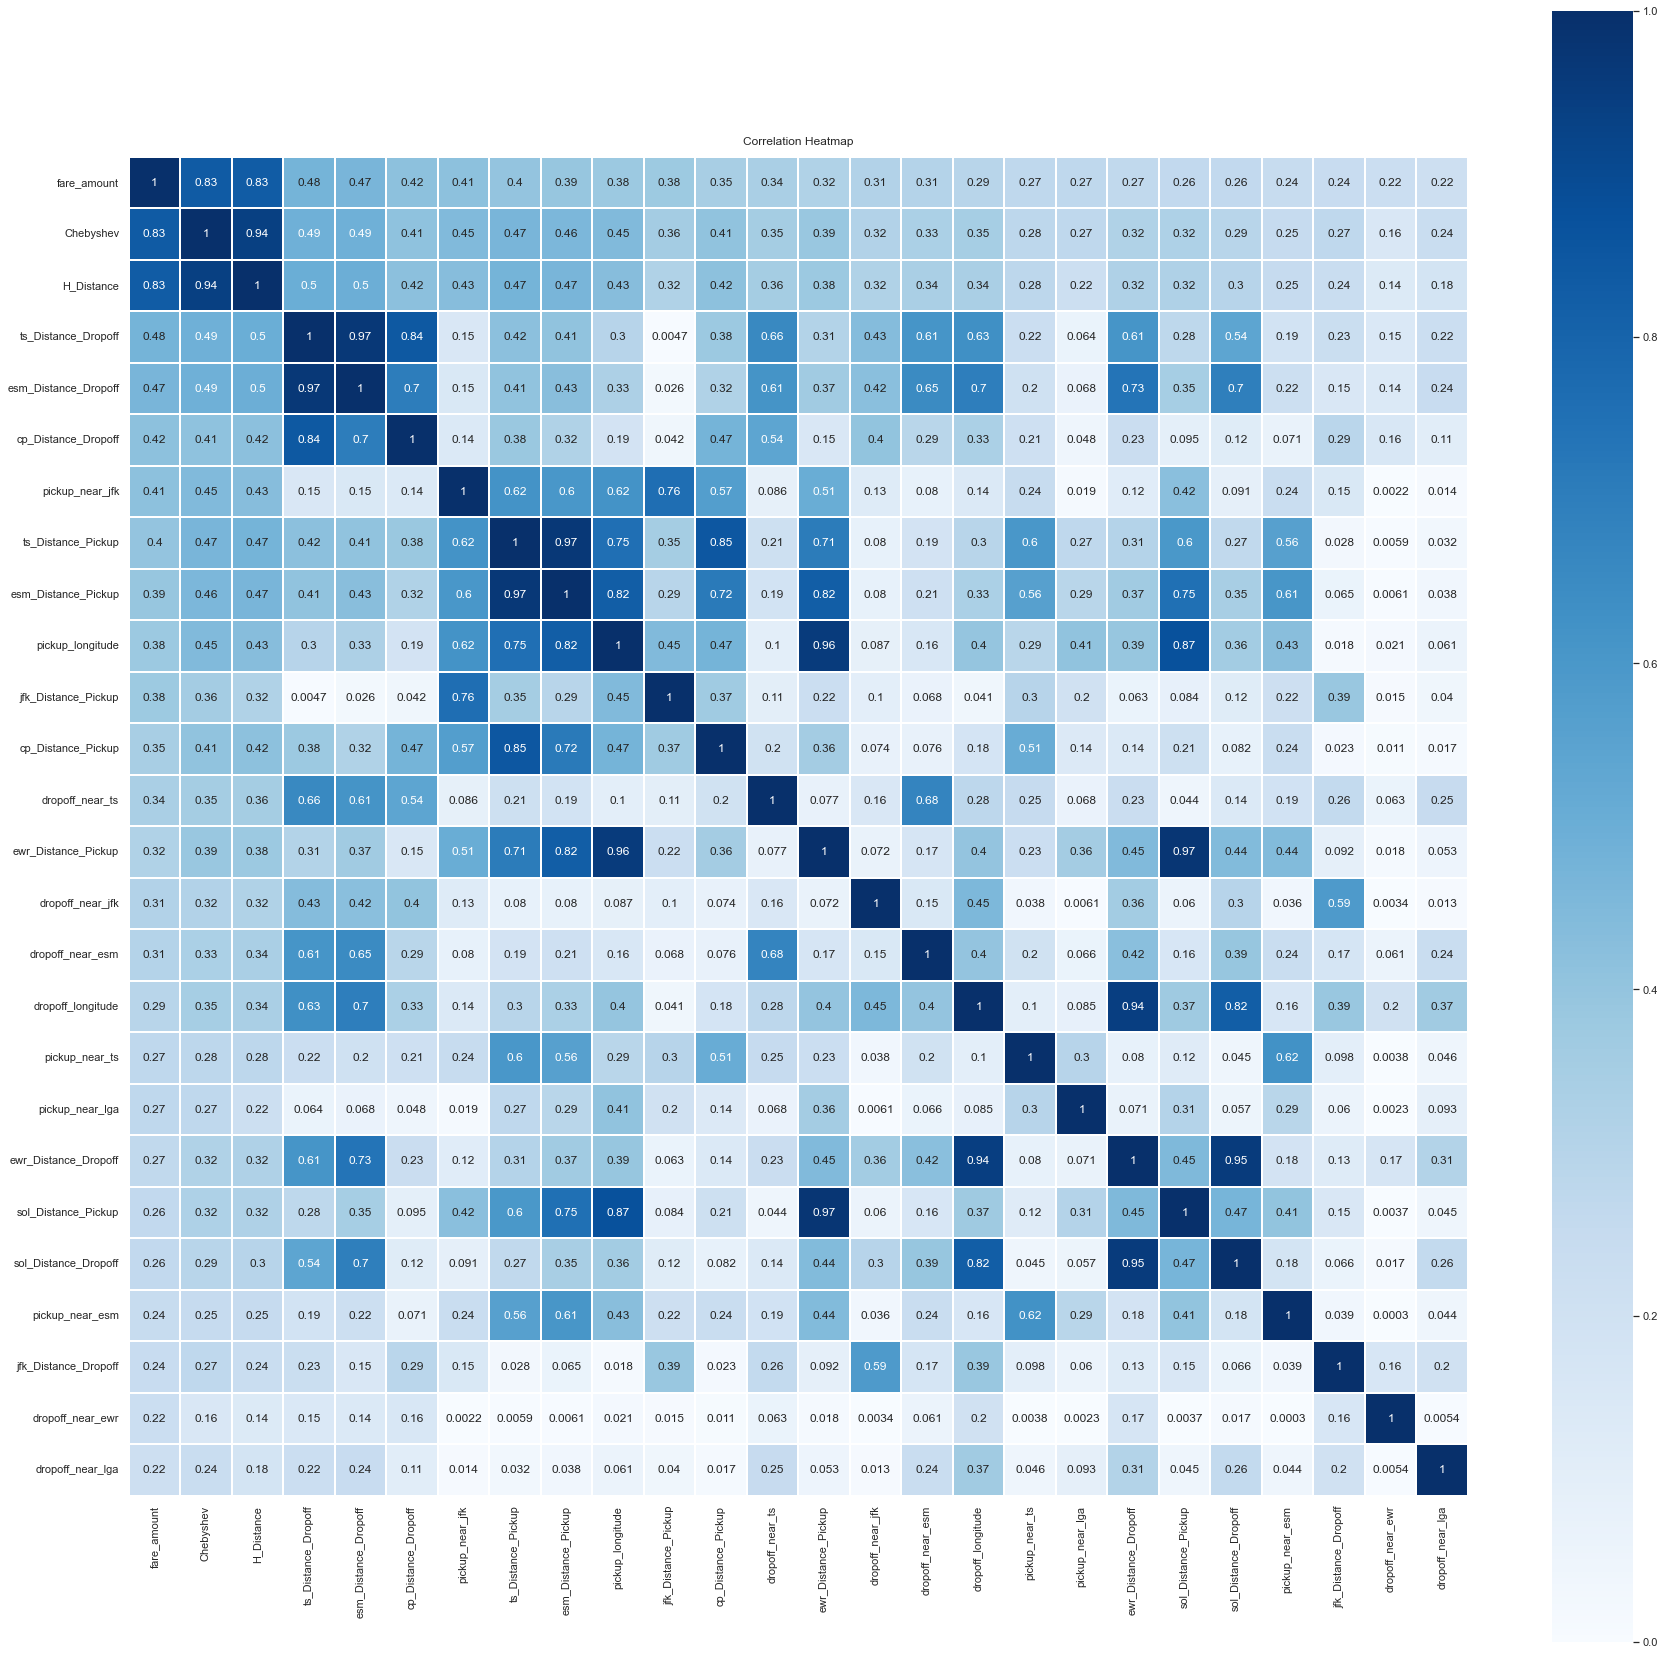

In [150]:
features = ['fare_amount', 'Chebyshev', 'H_Distance', 'ts_Distance_Dropoff', 'esm_Distance_Dropoff', 'cp_Distance_Dropoff', 'pickup_near_jfk', 'ts_Distance_Pickup', 'esm_Distance_Pickup', 'pickup_longitude', 'jfk_Distance_Pickup', 'cp_Distance_Pickup', 'dropoff_near_ts', 'ewr_Distance_Pickup', 'dropoff_near_jfk', 'dropoff_near_esm', 'dropoff_longitude', 'pickup_near_ts', 'pickup_near_lga', 'ewr_Distance_Dropoff', 'sol_Distance_Pickup', 'sol_Distance_Dropoff', 'pickup_near_esm', 'jfk_Distance_Dropoff', 'dropoff_near_ewr', 'dropoff_near_lga']

train_final = train[features]

colormap = plt.cm.RdBu
plt.figure(figsize=(30, 30))
heatmap = sns.heatmap(abs(train_final.corr()),linewidths=0.1,vmax=1.0,vmin=0, 
            square=True, cmap="Blues", linecolor='white', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

First, the Fare Amount is very much dependent on Chebyshev Distance and H_Distance but these are highly correlated themselves. We need to remove one of them.

We will remove the distance which is more correlated with other features.

In [151]:
train_final.corr()[['H_Distance', 'Chebyshev']].drop('fare_amount', axis=0).mean()

H_Distance    0.253377
Chebyshev     0.254767
dtype: float64

Since, Chebyshev is more correlated with other features, and also less correlated with the fare amount, we will remove Chebyshev.

In [152]:
train_final = train_final.drop(['Chebyshev'], axis=1)

Now let's again check the Heat-Map for the remaining features

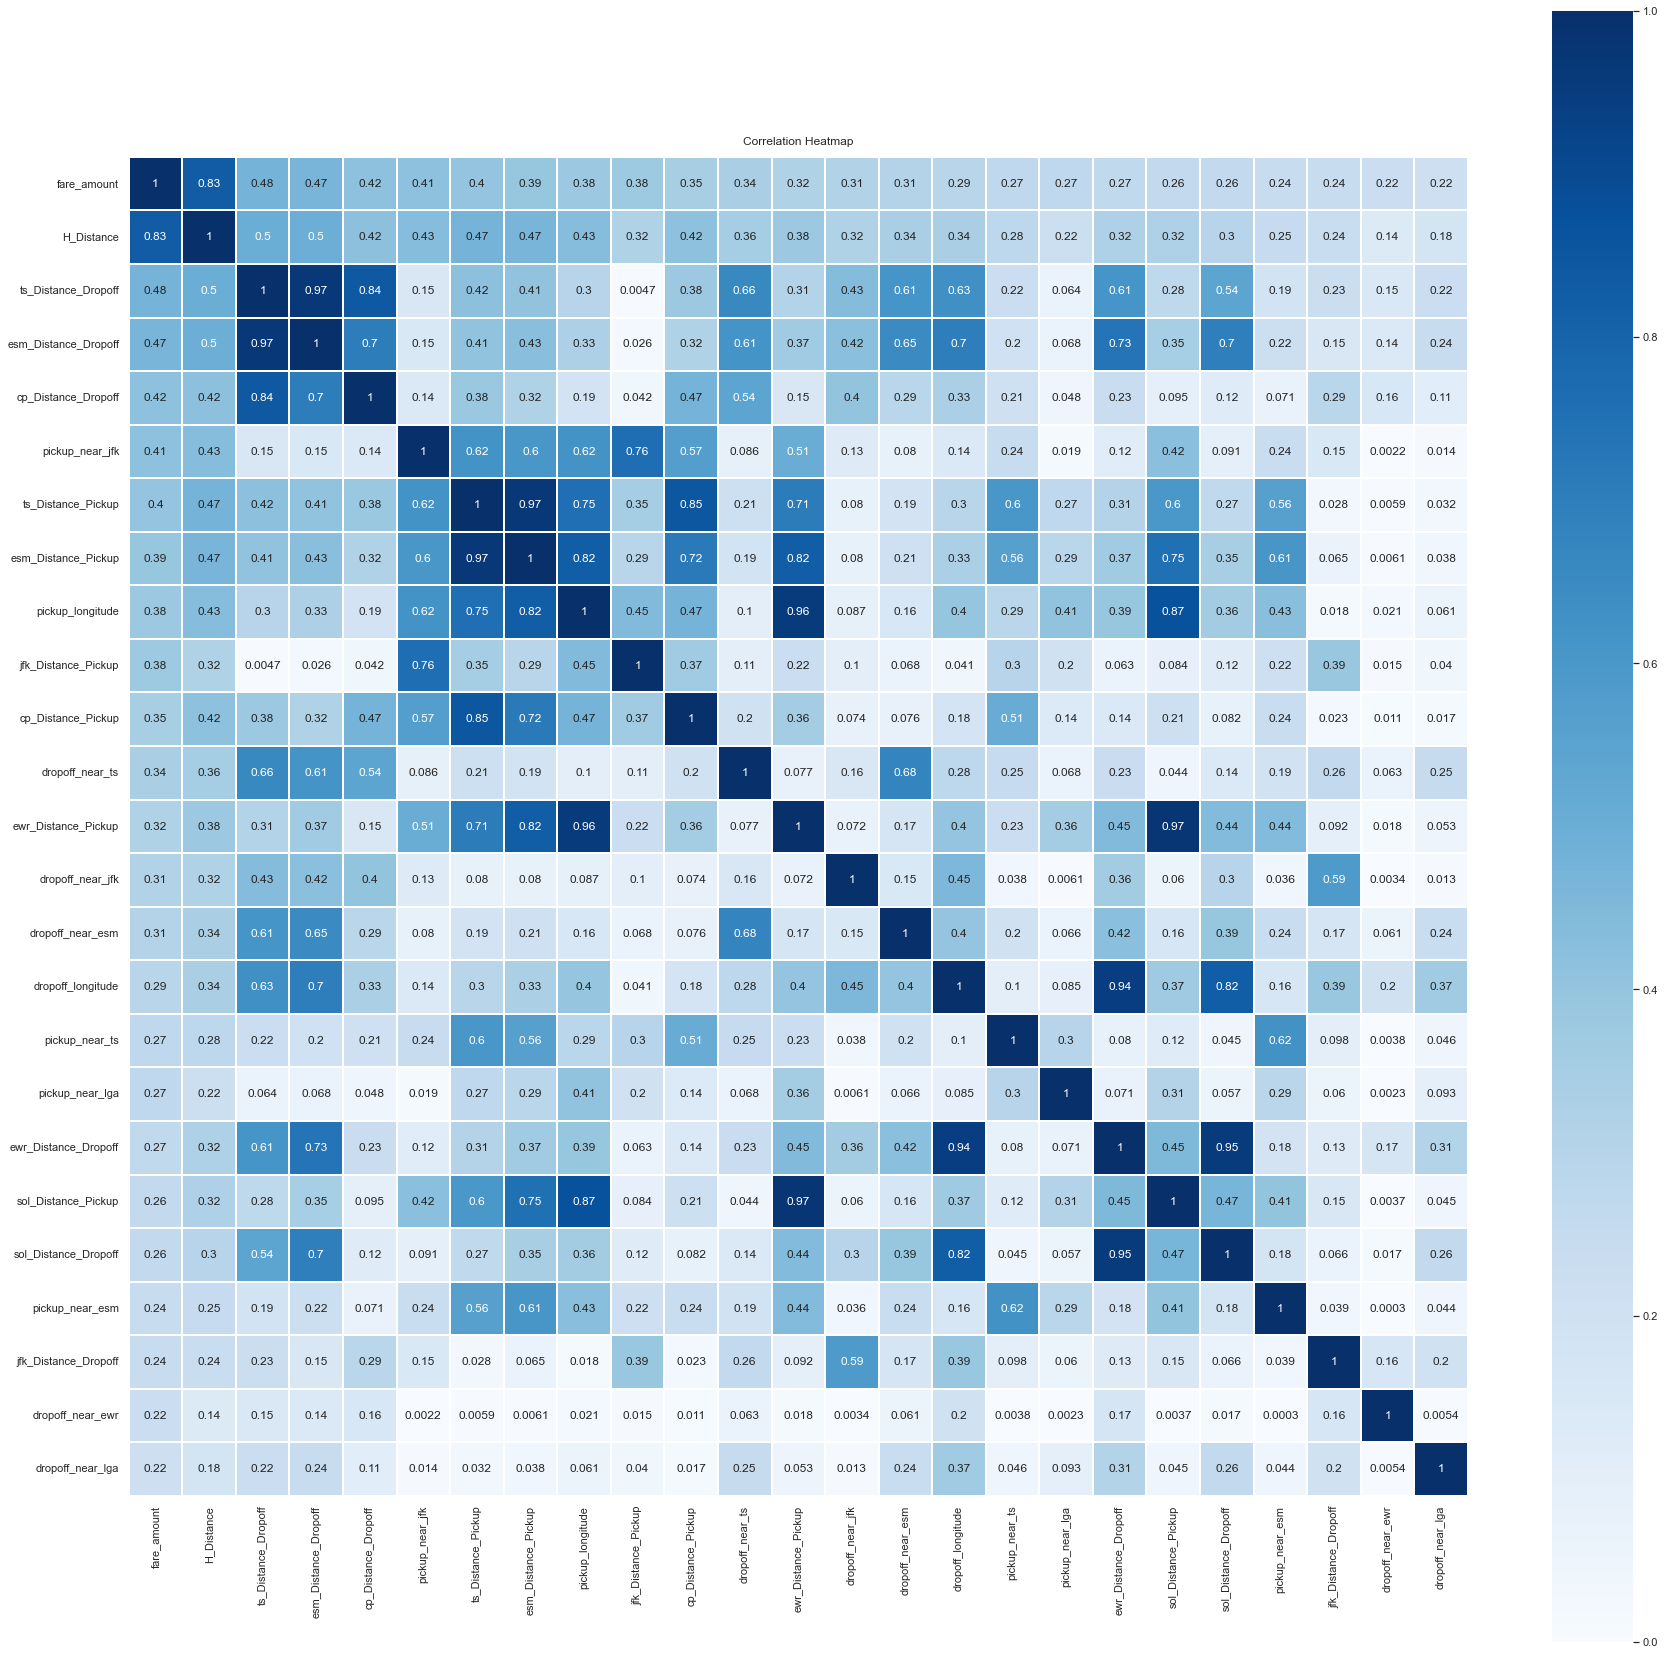

In [153]:
colormap = plt.cm.RdBu
plt.figure(figsize=(30, 30))
heatmap = sns.heatmap(abs(train_final.corr()),linewidths=0.1,vmax=1.0,vmin=0, 
            square=True, cmap="Blues", linecolor='white', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Still, many features are highly inter-correlated with each other leading to Multi-Collinearity.

We will consider a correlation of 0.85 as threshold for Multi-Collinearity.

Let's resolve the Multi-Collinearity!

In [154]:
current_features = (train_final.drop(['fare_amount'], axis=1).columns)
current_features

Index(['H_Distance', 'ts_Distance_Dropoff', 'esm_Distance_Dropoff',
       'cp_Distance_Dropoff', 'pickup_near_jfk', 'ts_Distance_Pickup',
       'esm_Distance_Pickup', 'pickup_longitude', 'jfk_Distance_Pickup',
       'cp_Distance_Pickup', 'dropoff_near_ts', 'ewr_Distance_Pickup',
       'dropoff_near_jfk', 'dropoff_near_esm', 'dropoff_longitude',
       'pickup_near_ts', 'pickup_near_lga', 'ewr_Distance_Dropoff',
       'sol_Distance_Pickup', 'sol_Distance_Dropoff', 'pickup_near_esm',
       'jfk_Distance_Dropoff', 'dropoff_near_ewr', 'dropoff_near_lga'],
      dtype='object')

In [155]:
filtered_df = train_final[current_features]

In [156]:
corr_df = filtered_df.corr()

In [157]:
visited = {}
multicolliniarity = []

# Check cells with values higher than 0.84
for row in corr_df.index:
    for col in corr_df.columns:
        if row == col:
            continue
        if (row, col) in visited:
            continue
        if (abs(corr_df.loc[row,col]) > 0.84):
            visited[(row,col)] = corr_df.loc[row,col]
            visited[(col,row)] = corr_df.loc[row,col]
            print(row, col, corr_df.loc[row,col])
            multicolliniarity.append((row, col, corr_df.loc[row,col]))

ts_Distance_Dropoff esm_Distance_Dropoff 0.9677481323059919
ts_Distance_Dropoff cp_Distance_Dropoff 0.8404271432157646
ts_Distance_Pickup esm_Distance_Pickup 0.9670165971884085
ts_Distance_Pickup cp_Distance_Pickup 0.8499750424703373
pickup_longitude ewr_Distance_Pickup 0.9558569255017142
pickup_longitude sol_Distance_Pickup 0.874431720619313
ewr_Distance_Pickup sol_Distance_Pickup 0.973875532427646
dropoff_longitude ewr_Distance_Dropoff 0.9417212692176328
ewr_Distance_Dropoff sol_Distance_Dropoff 0.9535464778998998


We need to resolve above Multi-Collinearity by removing the features which are highly correlated with other features.

In [158]:
multicolliniarity.sort(key=lambda tup: tup[2], reverse=True)

In [159]:
multicolliniarity

[('ewr_Distance_Pickup', 'sol_Distance_Pickup', 0.973875532427646),
 ('ts_Distance_Dropoff', 'esm_Distance_Dropoff', 0.9677481323059919),
 ('ts_Distance_Pickup', 'esm_Distance_Pickup', 0.9670165971884085),
 ('pickup_longitude', 'ewr_Distance_Pickup', 0.9558569255017142),
 ('ewr_Distance_Dropoff', 'sol_Distance_Dropoff', 0.9535464778998998),
 ('dropoff_longitude', 'ewr_Distance_Dropoff', 0.9417212692176328),
 ('pickup_longitude', 'sol_Distance_Pickup', 0.874431720619313),
 ('ts_Distance_Pickup', 'cp_Distance_Pickup', 0.8499750424703373),
 ('ts_Distance_Dropoff', 'cp_Distance_Dropoff', 0.8404271432157646)]

In [160]:
features_to_remove = []

In [161]:
for comparison in multicolliniarity:
    
    print("Comparing {} and {}".format(f1, f2))
    
    f1 = comparison[0]
    f2 = comparison[1]
    
    if f1 in features_to_remove or f2 in features_to_remove:
        continue
    # Let's check the average correlation for each feature with other features and also correlation with fare amount

    # Correlation with Fare Amount
    # print("Correlation with Fare_Amount")
    # print(abs(train_final.corr())[['fare_amount']].loc[f1])
    # print(abs(train_final.corr())[['fare_amount']].loc[f2])
    
    # More correlation is Better here
    difference = abs(train_final.corr())[['fare_amount']].loc[f1] - abs(train_final.corr())[['fare_amount']].loc[f2]

    # Correlation with other features
    # print(f1, "with other features:", abs(corr_df.corr())[f1].mean())
    # print(f2, "with other features", abs(corr_df.corr())[f2].mean())
    
    # Less correlation is Better here
    difference += abs(corr_df.corr())[f2].mean() - abs(corr_df.corr())[f1].mean()
    
    if difference.mean() > 0:
        print("Removing {}".format(f2))
        features_to_remove.append(f2)
    else:
        print("Removing {}".format(f1))
        features_to_remove.append(f1)


Comparing ts_Distance_Dropoff and cp_Distance_Dropoff
Removing sol_Distance_Pickup
Comparing ewr_Distance_Pickup and sol_Distance_Pickup
Removing esm_Distance_Dropoff
Comparing ts_Distance_Dropoff and esm_Distance_Dropoff
Removing esm_Distance_Pickup
Comparing ts_Distance_Pickup and esm_Distance_Pickup
Removing ewr_Distance_Pickup
Comparing pickup_longitude and ewr_Distance_Pickup
Removing ewr_Distance_Dropoff
Comparing ewr_Distance_Dropoff and sol_Distance_Dropoff
Comparing dropoff_longitude and ewr_Distance_Dropoff
Comparing pickup_longitude and sol_Distance_Pickup
Removing ts_Distance_Pickup
Comparing ts_Distance_Pickup and cp_Distance_Pickup
Removing ts_Distance_Dropoff


In [162]:
print("Following Features will be removed:")

list(set(features_to_remove))

Following Features will be removed:


['esm_Distance_Pickup',
 'ewr_Distance_Dropoff',
 'esm_Distance_Dropoff',
 'ewr_Distance_Pickup',
 'ts_Distance_Pickup',
 'sol_Distance_Pickup',
 'ts_Distance_Dropoff']

In [163]:
train_final = train_final.drop(features_to_remove, axis=1)

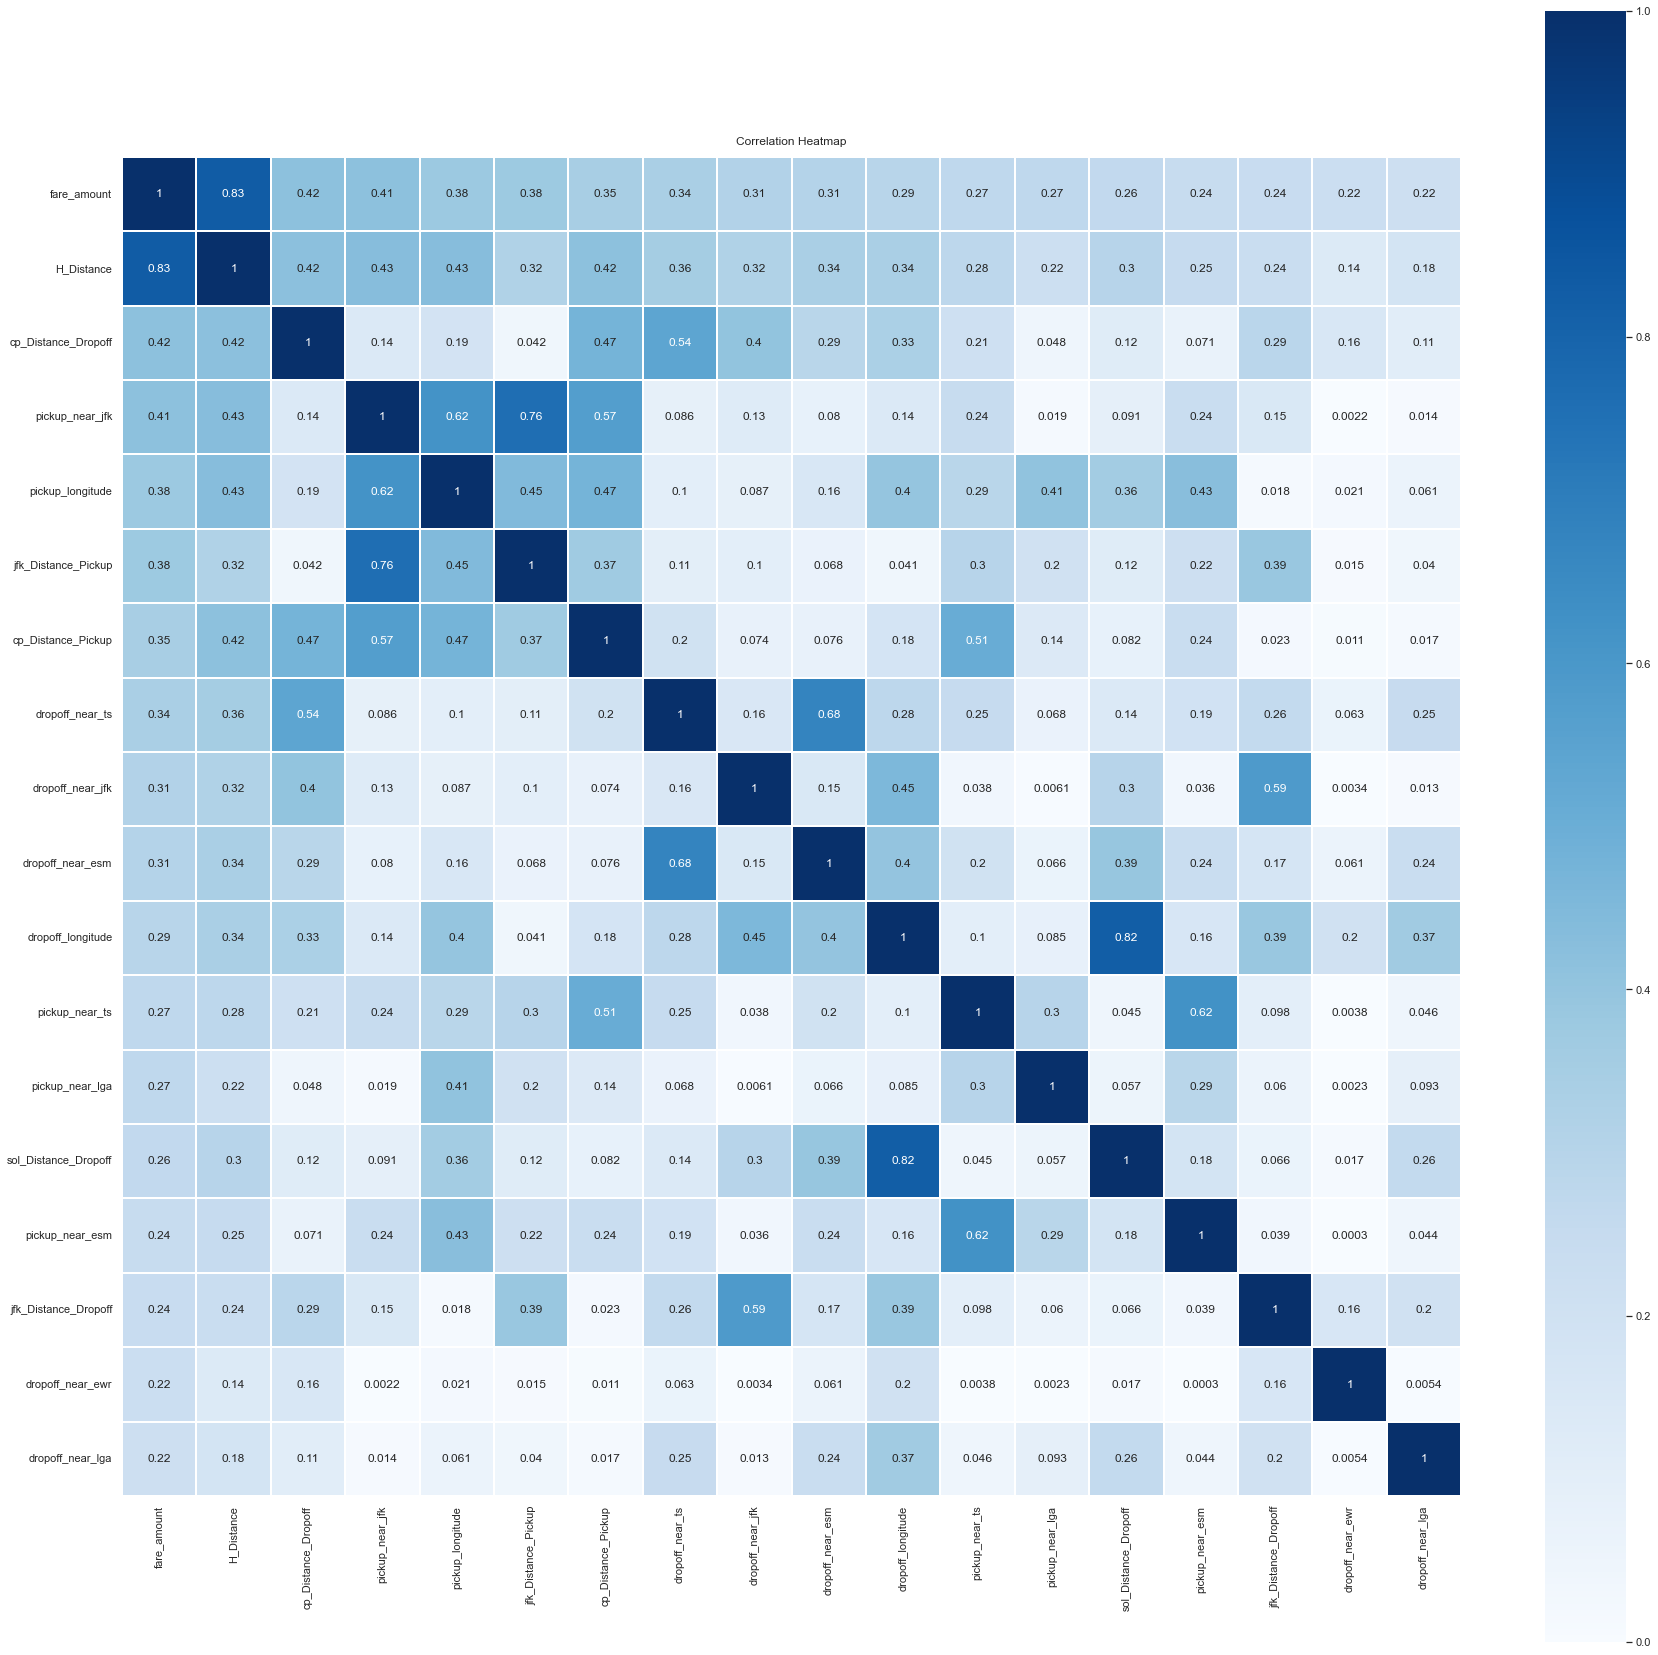

In [164]:
colormap = plt.cm.RdBu
plt.figure(figsize=(30, 30))
heatmap = sns.heatmap(abs(train_final.corr()),linewidths=0.1,vmax=1.0,vmin=0, 
            square=True, cmap="Blues", linecolor='white', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Trying Feature Selection using OLS

In [165]:
train_final.drop('fare_amount', axis=1).columns

Index(['H_Distance', 'cp_Distance_Dropoff', 'pickup_near_jfk',
       'pickup_longitude', 'jfk_Distance_Pickup', 'cp_Distance_Pickup',
       'dropoff_near_ts', 'dropoff_near_jfk', 'dropoff_near_esm',
       'dropoff_longitude', 'pickup_near_ts', 'pickup_near_lga',
       'sol_Distance_Dropoff', 'pickup_near_esm', 'jfk_Distance_Dropoff',
       'dropoff_near_ewr', 'dropoff_near_lga'],
      dtype='object')

In [166]:
y = train_final['fare_amount'].values
x = train_final.drop(['fare_amount'], axis=1).to_numpy()

In [167]:
from sklearn.preprocessing import StandardScaler

# Scale X
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = sm.add_constant(x)

In [168]:
esm = sm.OLS(y, x)
esm = esm.fit()

In [169]:
esm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                 1.713e+05
Date:                Sun, 21 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:39:59   Log-Likelihood:            -2.9287e+06
No. Observations:              975512   AIC:                         5.857e+06
Df Residuals:                  975494   BIC:                         5.858e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3390      0.005   2299.195      0.000      11.329      11.349
x1             6.8416      0.007   1007.991      0.000       6.828       6.855
x2             1.5107      0.009    176.198      0.000       1.494       1.527
x3             0.8341      0.012     67.544      0.000       0.810       0.858
x4            -1.0242      0.010   -107.321      0.000      -1.043      -1.005
x5            -1.6112      0.010   -155.331      0.000      -1.632      -1.591
x6            -1.1070      0.009   -128.071      0.000      -1.124      -1.090
x7             0.1133      0.008     13.946      0.000       0.097       0.129
x8             0.3512      0.008     42.077      0.000       0.335       0.368
x9             0.1660      0.008     21.851      0.000       0.151       0.181
x10           -0.3479      0.021    -16.930      0.000      -0.388      -0.308
x11           -0.2058      0.008    -26.565      0.000      -0.221      -0.191
x12            1.1677      0.007    169.127      0.000       1.154       1.181
x13            0.8629      0.019     46.184      0.000       0.826       0.900
x14           -0.1622      0.007    -22.875      0.000      -0.176      -0.148
x15            0.4540      0.013     34.762      0.000       0.428       0.480
x16            0.8883      0.006    145.010      0.000       0.876       0.900
x17            0.6385      0.006    110.307      0.000       0.627       0.650
==============================================================================
Omnibus:                  1205010.767   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      12549898338.308
Skew:                           5.313   Prob(JB):                         0.00
Kurtosis:                     558.559   Cond. No.                         13.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As per the Above Feature Selection using OLS, it seems that almost all the features are Important.

As we had seen above, we saw that Fare_Prices increased throughout the years. So, we will also add Year as a feature

In [172]:
final_features = list(train_final.drop(['fare_amount'], axis=1).columns)
final_features.append('year')
for feature in final_features:
    print(feature)

H_Distance
cp_Distance_Dropoff
pickup_near_jfk
pickup_longitude
jfk_Distance_Pickup
cp_Distance_Pickup
dropoff_near_ts
dropoff_near_jfk
dropoff_near_esm
dropoff_longitude
pickup_near_ts
pickup_near_lga
sol_Distance_Dropoff
pickup_near_esm
jfk_Distance_Dropoff
dropoff_near_ewr
dropoff_near_lga
year


Now, we will move on to Data-Preprocessing part in the next notebook.